# Panel Fixed Effects for Causal Inference

Suppose we want to estimate the effect of a training program on earnings. Workers who take it may be more motivated or able to begin with. If we simply compare trained vs untrained workers, we mix the program effect with that pre-existing difference—our estimate is confounded. **Panel data** (the same units observed over time) and **fixed effects** let us control for such time-invariant differences by comparing each unit to itself. This notebook shows when that works, when it fails, and how to do it in CausalPy.

**Panel data** tracks the same units (workers, firms, countries) over multiple time periods. **Fixed effects** exploits this structure to control for unobserved confounders—either **unit-specific characteristics**, **common time shocks**, or both.

**Unit-specific characteristics** are traits that differ across units but are roughly stable over time for each unit. They can be observed (e.g., industry, region) or unobserved (e.g., managerial talent, culture). Examples by setting:

- **Workers:** innate ability, motivation, risk tolerance, education (if unchanging in the panel).
- **Firms:** management quality, corporate culture, brand strength, baseline productivity.
- **Regions or countries:** institutions, legal tradition, geography, norms.

**Common time shocks** are events or conditions at a given time that affect all units in the panel in a similar way (even if intensity varies). Examples:

- **Macroeconomic:** recessions, interest-rate cycles, commodity price spikes, exchange-rate moves.
- **Policy:** a nationwide minimum-wage change, a new regulation, or a tax reform that applies to all units.
- **Technology or information:** adoption of a new technology, a widely publicized health finding, or a common demand shock (e.g., pandemic).

:::{note}
**Why this matters for causal inference.** If treatment assignment is correlated with unit-level traits (e.g., better firms adopt the policy first) or with common time shocks (e.g., treatment rolls out in a recession), naive comparisons are confounded. Fixed effects remove the part of the variation in the outcome that is explained by unit dummies (unit FE), time dummies (time FE), or both, so we can isolate the effect of treatment.
:::

**Roadmap.** We first set up the **confounding problem** and the **fixed-effects toolbox** (dummies vs demeaned). Then we work through four examples: **one-way unit FE** (simulation with known truth), **when FE fails** (time-varying confounder), **two-way FE** (state–year policy), and **large-panel demeaned** (workers × waves). We end with **when to use FE**, **how to choose** unit/time/two-way, and **limitations**.

**Two ways to implement fixed effects.** We can control for unit (or time) effects in either of two equivalent ways: (1) **dummy variables**—include a separate intercept for each unit and/or time period—or (2) **demeaned transformation**—subtract from each variable its mean *within* the group (e.g. within unit). Demeaning removes any part of the outcome that is constant within that group (such as $u_i$ within unit $i$), so we get the same causal estimate without estimating hundreds of nuisance parameters. We'll use both approaches in the examples below so you see that they give identical results.

For a deeper treatment of panel data methods and causal inference, see {cite:t}`cunningham2021causal` ([Chapter 8](https://mixtape.scunning.com/08-panel_data)), {cite:t}`huntington2021effect`, and {cite:t}`wooldridge2010econometric`.

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression

import causalpy as cp

warnings.filterwarnings("ignore")

%config InlineBackend.figure_format = 'retina'
plt.style.use("default")

%load_ext autoreload
%autoreload 2

# Figure sizing (consistent width for all figures; multiply height only when needed)
FIG_WIDTH = 10
FIG_HEIGHT = 5

# Sampling settings for Bayesian models
sample_kwargs = {
    "draws": 2000,
    "tune": 1000,
    "chains": 4,
    "target_accept": 0.95,
    "random_seed": 42,
}

## The Confounding Problem

The standard panel data model is:

$$y_{it} = \beta D_{it} + u_i + \gamma_t + \epsilon_{it}$$

where $D_{it}$ is treatment and $\epsilon_{it}$ is idiosyncratic error. The terms $u_i$ and $\gamma_t$ are **nuisance parameters** we must account for to get an unbiased estimate of the causal effect $\beta$:

- $u_i$ captures everything about unit $i$ that is constant over time but affects the outcome (e.g., a worker's innate ability, a firm's culture). There is one $u_i$ parameter per unit.
- $\gamma_t$ captures shocks at time $t$ that affect all units equally (e.g., a recession, a policy change). There is one $\gamma_t$ parameter per time period.

These become confounders if they also influence treatment assignment:

| Confounder | What it is | Example | Solution |
|------------|-----------|---------|----------|
| $u_i$ (unit effect) | Time-invariant unit characteristics | Worker ability, firm culture | **Unit FE** |
| $\gamma_t$ (time effect) | Common shocks affecting all units | Recessions, policy changes | **Time FE** |

Without accounting for these, any correlation between $D_{it}$ and $u_i$ or $\gamma_t$ biases our estimate. The DAG below illustrates both confounding paths:

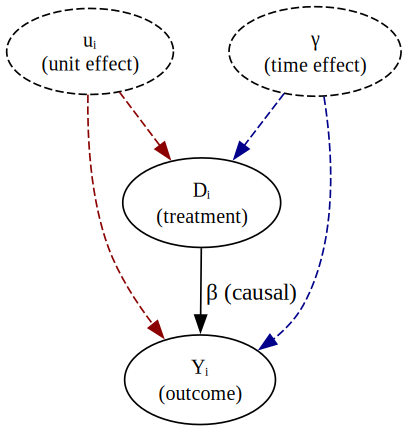

In [2]:
from graphviz import Digraph

# DAG showing both unit and time confounders
dag = Digraph(comment="Panel Data Confounders", graph_attr={"dpi": "120"})
dag.attr(rankdir="TB", size="7,5")
dag.attr("node", shape="ellipse", fontsize="12")

# Nodes
dag.node("U", "uᵢ\n(unit effect)", style="dashed")
dag.node("G", "γₜ\n(time effect)", style="dashed")
dag.node("D", "Dᵢₜ\n(treatment)")
dag.node("Y", "Yᵢₜ\n(outcome)")

# Confounding paths (dashed = unobserved)
dag.edge("U", "D", style="dashed", color="darkred")
dag.edge("U", "Y", style="dashed", color="darkred")
dag.edge("G", "D", style="dashed", color="darkblue")
dag.edge("G", "Y", style="dashed", color="darkblue")

# Causal path
dag.edge("D", "Y", label="  β (causal)")

dag

**Figure (DAG).** Nodes: $u_i$ (unit effect) and $\gamma_t$ (time effect), unobserved, dashed ellipses; $D_{it}$ (treatment), $Y_{it}$ (outcome). Red dashed edges: unit confounding paths ($u_i \to D$, $u_i \to Y$). Blue dashed edges: time confounding paths ($\gamma_t \to D$, $\gamma_t \to Y$). Solid black edge: causal effect $\beta$.

In summary, estimating the causal effect of treatment on the outcome risks bias from time-invariant unit effects, common temporal shocks, or both {cite:p}`imaikim2019fixed`. These confounders create backdoor paths. Normally we would close backdoor paths by conditioning, but we can't do that directly here because they are unobserved. However, because these confounders have a specific structure (constant within units or across units), adding fixed effects can effectively close these backdoor paths.

## The Fixed Effects Toolbox

Fixed effects controls for confounders by comparing units to themselves (unit FE) or comparing across units within the same time period (time FE).

**Dummy variables vs demeaned transformation.** We can implement this either by including a dummy (intercept) for each unit and/or time period, or by **demeaning**: subtract from each variable its average within the group. For example, to remove unit effects we subtract the unit mean—for unit $i$, $\bar{y}_{i\cdot}$ is the average of $y_{it}$ over time. Anything constant within the unit (including $u_i$) then drops out ($u_i - \bar{u}_{i\cdot} = 0$), so we don't need to estimate it. The same idea applies to time: subtract the period mean to remove $\gamma_t$. Both approaches give the same treatment-effect estimate; we use both in the examples so you can see that, and we prefer demeaning when there are many units or periods to avoid estimating hundreds of coefficients.

**Formulas.** One-way (unit) demeaning: $\tilde{y}_{it} = y_{it} - \bar{y}_{i\cdot}$. Two-way (unit and time): $\tilde{y}_{it} = y_{it} - \bar{y}_{i\cdot} - \bar{y}_{\cdot t} + \bar{y}_{\cdot\cdot}$. The two-way formula is equivalent to the dummy-variable approach for balanced panels.

| FE Type | Controls for |
|---------|--------------|
| Unit FE | $u_i$ - time-invariant unit characteristics |
| Time FE | $\gamma_t$ - common shocks affecting all units |
| Two-way FE | Both $u_i$ and $\gamma_t$ |

**Key assumptions** for fixed effects to identify causal effects {cite:p}`imaikim2019fixed`:

- **Strict exogeneity**: No feedback from past outcomes to current treatment
- **No time-varying confounders**: Only time-invariant confounders exist (the key limitation!)
- **Treatment varies within units**: Need some units to change treatment status over time
- **Parallel trends** (for two-way FE): Connects to difference-in-differences assumptions

## Example 1: One-Way Fixed Effects (Unit Only)

This example demonstrates **one-way unit fixed effects**—we control for time-invariant unit characteristics but NOT for common time trends.

**When is this appropriate?**
- Time trends are not a major concern (no common shocks affecting all units)
- Or time effects are captured by covariates in the model
- You want to preserve cross-sectional variation that time FE would remove

**Data-generating process (DGP).** The simulated data are built to match the model $y_{it} = \beta D_{it} + u_i + \gamma_t + \epsilon_{it}$ with a known $\beta$:
- **Unit confounder $u_i$:** Yes. Each unit has a time-invariant draw $u_i$ that shifts the outcome. Treatment is assigned to the first half of units from period 10 onward, so treatment is correlated with unit identity—and therefore with $u_i$. That creates confounding: naive OLS will be biased.
- **Time confounder $\gamma_t$:** No. We do not add any common period shock in this simulation, so there is no time-level confounding. One-way unit FE is the appropriate control; we add time FE later only to show it leaves the estimate unchanged when there is no $\gamma_t$.

This example is designed to satisfy all the identifying assumptions:

- ✅ Time-invariant confounders only (unit effects $u_i$)
- ✅ No feedback from outcomes to treatment
- ✅ No time-varying confounders
- ✅ Treatment varies within units over time

**Causal question:** What is the effect of treatment on the outcome, controlling for unobserved unit-level heterogeneity?

In [3]:
# Set up random number generator
rng = np.random.default_rng(42)

# Panel dimensions
n_units = 20
n_periods = 15
treatment_time = 10

# True parameters
TRUE_TREATMENT_EFFECT = 3.0
TRUE_X_COEF = 0.5

# Generate panel data: y_it = β*D_it + u_i + 0*t + ε_it (no γ_t in this example)
data = []
for i in range(n_units):
    unit_effect = rng.normal(scale=2.0)  # Unit confounder u_i (time-invariant)

    for t in range(n_periods):
        x1 = rng.normal()
        # First half of units get treated after treatment_time → D correlated with unit (hence u_i)
        treatment = 1 if (t >= treatment_time and i < n_units // 2) else 0

        y = (
            unit_effect
            + TRUE_TREATMENT_EFFECT * treatment
            + TRUE_X_COEF * x1
            + rng.normal(scale=0.5)
        )
        # No γ_t term: no time confounder in this DGP

        data.append(
            {
                "unit": f"unit_{i}",
                "time": t,
                "treatment": treatment,
                "x1": x1,
                "y": y,
            }
        )

df_sim = pd.DataFrame(data)
print(f"Panel: {n_units} units, {n_periods} periods")
print(f"True treatment effect: {TRUE_TREATMENT_EFFECT}")
df_sim.head()

Panel: 20 units, 15 periods
True treatment effect: 3.0


,unit,time,treatment,x1,y
0,unit_0,0,0,-1.039984,0.464668
1,unit_0,1,0,0.940565,0.104199
2,unit_0,2,0,-1.302180,0.022265
3,unit_0,3,0,-0.316243,0.442912
4,unit_0,4,0,-0.853044,0.622611


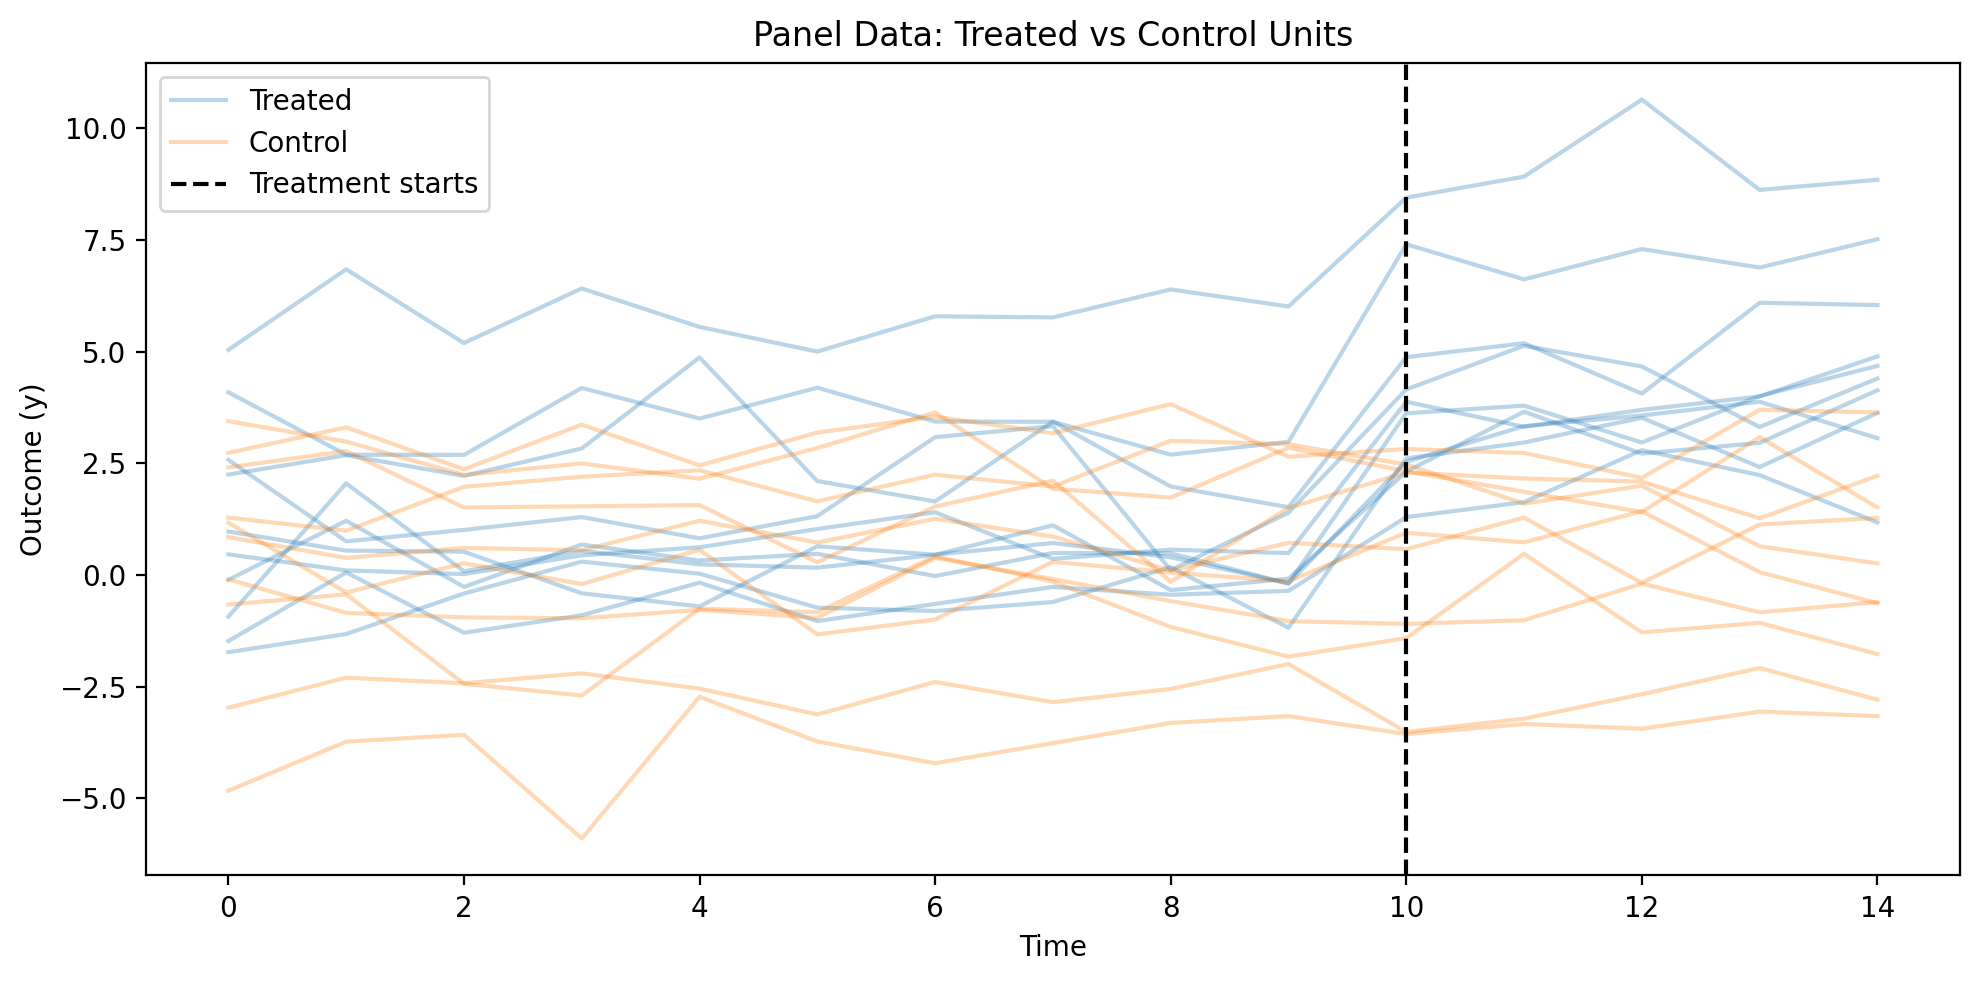

In [4]:
# Visualize the simulated panel data
fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT))

# Add treatment group indicator
df_sim["group"] = df_sim["unit"].apply(
    lambda x: "Treated" if int(x.split("_")[1]) < 10 else "Control"
)

sns.lineplot(
    data=df_sim,
    x="time",
    y="y",
    hue="group",
    units="unit",
    estimator=None,
    alpha=0.3,
    ax=ax,
)
ax.axvline(x=treatment_time, color="black", linestyle="--", label="Treatment starts")
ax.set_xlabel("Time")
ax.set_ylabel("Outcome (y)")
ax.set_title("Panel Data: Treated vs Control Units")
ax.legend()
plt.tight_layout()

**Figure (Example 1).** Outcome $y$ by time (periods 0–14); one line per unit, grouped by treated vs control. Vertical black dashed line: treatment start ($t = 10$). True treatment effect in the DGP is $\beta = 3$.

### Naive OLS (Biased)

First, let's see what happens if we ignore the unit fixed effects:

In [5]:
# Naive OLS without fixed effects
X_naive = df_sim[["treatment", "x1"]].values
y_naive = df_sim["y"].values

naive_model = LinearRegression().fit(X_naive, y_naive)
print("Naive OLS (NO fixed effects):")
print(f"  Treatment effect: {naive_model.coef_[0]:.3f} (True: {TRUE_TREATMENT_EFFECT})")
print(f"  Bias: {naive_model.coef_[0] - TRUE_TREATMENT_EFFECT:.3f}")

Naive OLS (NO fixed effects):
  Treatment effect: 3.796 (True: 3.0)
  Bias: 0.796


### Fixed Effects with Dummies

In [6]:
# One-way unit FE with dummy variables (Bayesian)
# Note: time_fe_variable is not set, so we only control for unit effects
result_dummies = cp.PanelRegression(
    data=df_sim,
    formula="y ~ C(unit) + treatment + x1",  # No C(time) - unit FE only
    unit_fe_variable="unit",
    fe_method="dummies",
    model=cp.pymc_models.LinearRegression(sample_kwargs=sample_kwargs),
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]


In [7]:
result_dummies.summary()


Panel Regression
Units: 20 (unit)
FE method: dummies
Observations: 300

Note: 19 fixed effect coefficients not shown (use print_coefficients() to see all)

Model Coefficients:
Model coefficients:
    Intercept    0.75, 94% HDI [0.49, 1]
    treatment    3.1, 94% HDI [2.9, 3.3]
    x1           0.5, 94% HDI [0.44, 0.56]
    y_hat_sigma  0.51, 94% HDI [0.47, 0.56]


The treatment effect estimate (`treatment 3.1, 94% HDI [2.9, 3.3]`) closely recovers the true value of 3.0, and the 94% HDI contains the true parameter. This demonstrates that one-way unit fixed effects successfully removes the bias from time-invariant unit confounders $u_i$.

### Same estimate via demeaned transformation

We now use the demeaned transformation (introduced in the Toolbox): subtract each variable's mean within the unit. No unit dummies in the formula—the transformation handles it. The estimate is identical:

In [8]:
# One-way unit FE with demeaned transformation (Bayesian)
# Note: time_fe_variable is not set, so we only control for unit effects
result_demeaned = cp.PanelRegression(
    data=df_sim,
    formula="y ~ treatment + x1",  # No C(unit) needed with demeaned transformation!
    unit_fe_variable="unit",
    # time_fe_variable not set = one-way unit FE
    fe_method="demeaned",
    model=cp.pymc_models.LinearRegression(sample_kwargs=sample_kwargs),
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]


In [9]:
result_demeaned.summary()


Panel Regression
Units: 20 (unit)
FE method: demeaned
Observations: 300

Model Coefficients:
Model coefficients:
    Intercept    1.1e-05, 94% HDI [-0.054, 0.053]
    treatment    3.1, 94% HDI [3, 3.3]
    x1           0.5, 94% HDI [0.44, 0.56]
    y_hat_sigma  0.5, 94% HDI [0.46, 0.54]


### Interpreting the Results

The treatment coefficient of approximately **3.1** (true value: 3.0) represents the **within-unit causal effect** of treatment on the outcome. 

**What this means:** For the same unit, receiving treatment increases the outcome by about 3 units on average, after controlling for all time-invariant unit characteristics.

**Key insight:** This estimate comes from comparing each unit to *itself* at different time points - not from comparing treated units to control units. This is why fixed effects can control for unobserved unit-level confounders.

The Bayesian credible interval provides uncertainty quantification: we're 94% confident the true effect lies within this range.


### Comparing One-Way vs Two-Way Fixed Effects

Recall that our simulated data includes unit-specific confounders ($u_i$) but no common time shocks ($\gamma_t$) that affect all units equally. What happens if we add time fixed effects anyway? Let's compare:

1. **One-way (unit only):** What we just estimated above
2. **Two-way (unit + time):** Adding time fixed effects

Since there are no time shocks in this data, we expect both estimates to be similar. This illustrates that adding unnecessary fixed effects doesn't bias estimates—but it does consume degrees of freedom.


In [10]:
# Two-way FE: Add time fixed effects to the same data
result_twoway = cp.PanelRegression(
    data=df_sim,
    formula="y ~ treatment + x1",  # Demeaned transformation handles both unit and time
    unit_fe_variable="unit",
    time_fe_variable="time",  # <-- This adds time FE!
    fe_method="demeaned",
    model=cp.pymc_models.LinearRegression(sample_kwargs=sample_kwargs),
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]


In [11]:
# Compare the treatment effect estimates
print("=" * 60)
print("COMPARISON: One-Way vs Two-Way Fixed Effects")
print("=" * 60)
print(f"\nTrue treatment effect: 3.0")
print(f"\nOne-way (unit FE only):")
print(
    f"  Treatment coefficient: {result_demeaned.model.idata.posterior['beta'].sel(coeffs='treatment').mean().values:.3f}"
)
print(f"\nTwo-way (unit + time FE):")
print(
    f"  Treatment coefficient: {result_twoway.model.idata.posterior['beta'].sel(coeffs='treatment').mean().values:.3f}"
)
print("\nIn this case, both estimates are similar because the simulated data")
print("doesn't have strong common time trends that confound treatment.")

COMPARISON: One-Way vs Two-Way Fixed Effects

True treatment effect: 3.0

One-way (unit FE only):
  Treatment coefficient: 3.120

Two-way (unit + time FE):
  Treatment coefficient: 3.071

In this case, both estimates are similar because the simulated data
doesn't have strong common time trends that confound treatment.


:::{tip}
**When does the choice matter?**

The estimates from one-way and two-way FE will differ when:
- There are **common time shocks** (e.g., a recession affecting all units) that correlate with treatment
- Treatment rollout is **correlated with time trends** (e.g., early adopters vs late adopters)

If neither condition applies, one-way unit FE is often sufficient and more parsimonious.
:::


## Example 2: When Fixed Effects Fails

The simulation above worked because our data satisfied all the identifying assumptions. But what happens when those assumptions are violated? We continue with one-way unit fixed effects to isolate the problem.

Here we add a **time-varying confounder**—an economic shock that varies by unit *and* time—that affects both treatment and outcome. Workers are more likely to seek training during good economic times, and the shock also directly affects productivity. Unit fixed effects cannot remove this confounder because it changes over time, and time fixed effects cannot remove it either because it varies across units. **No combination of fixed effects can eliminate confounders that vary in both dimensions.**


In [12]:
# Simulate data with a TIME-VARYING confounder
rng = np.random.default_rng(42)

n_units = 20
n_periods = 15
TRUE_TREATMENT_EFFECT = 3.0  # Same as before

data_violation = []
for i in range(n_units):
    unit_effect = rng.normal(scale=2.0)  # Time-invariant (FE handles this)

    for t in range(n_periods):
        # TIME-VARYING confounder: an economic shock that varies by unit AND time
        economic_shock = rng.normal(scale=1.5)

        # Treatment is AFFECTED by the economic shock (more likely to train during good times)
        treatment_propensity = 0.3 + 0.3 * (economic_shock > 0)
        treatment = 1 if (rng.random() < treatment_propensity and t >= 5) else 0

        # Outcome is affected by treatment AND the economic shock
        y = (
            unit_effect
            + TRUE_TREATMENT_EFFECT * treatment
            + 2.0 * economic_shock  # Direct effect of confounder on outcome
            + rng.normal(scale=0.5)
        )

        data_violation.append(
            {"unit": f"unit_{i}", "time": t, "treatment": treatment, "y": y}
        )

df_violation = pd.DataFrame(data_violation)

In [13]:
# Apply fixed effects
result_violation = cp.PanelRegression(
    data=df_violation,
    formula="y ~ treatment",
    unit_fe_variable="unit",
    fe_method="demeaned",
    model=LinearRegression(),
)

In [14]:
treatment_idx = result_violation.labels.index("treatment")
biased_estimate = np.squeeze(result_violation.model.coef_)[treatment_idx]

print("=" * 60)
print("FIXED EFFECTS WITH TIME-VARYING CONFOUNDER")
print("=" * 60)
print(f"True treatment effect:      {TRUE_TREATMENT_EFFECT:.2f}")
print(f"FE estimate:                {biased_estimate:.2f}")
print(f"Bias:                       {biased_estimate - TRUE_TREATMENT_EFFECT:.2f}")
print()
print("⚠️  The estimate is BIASED because the economic shock")
print("   affects both treatment and outcome, and FE cannot remove it!")
print("=" * 60)

FIXED EFFECTS WITH TIME-VARYING CONFOUNDER
True treatment effect:      3.00
FE estimate:                3.93
Bias:                       0.93

⚠️  The estimate is BIASED because the economic shock
   affects both treatment and outcome, and FE cannot remove it!


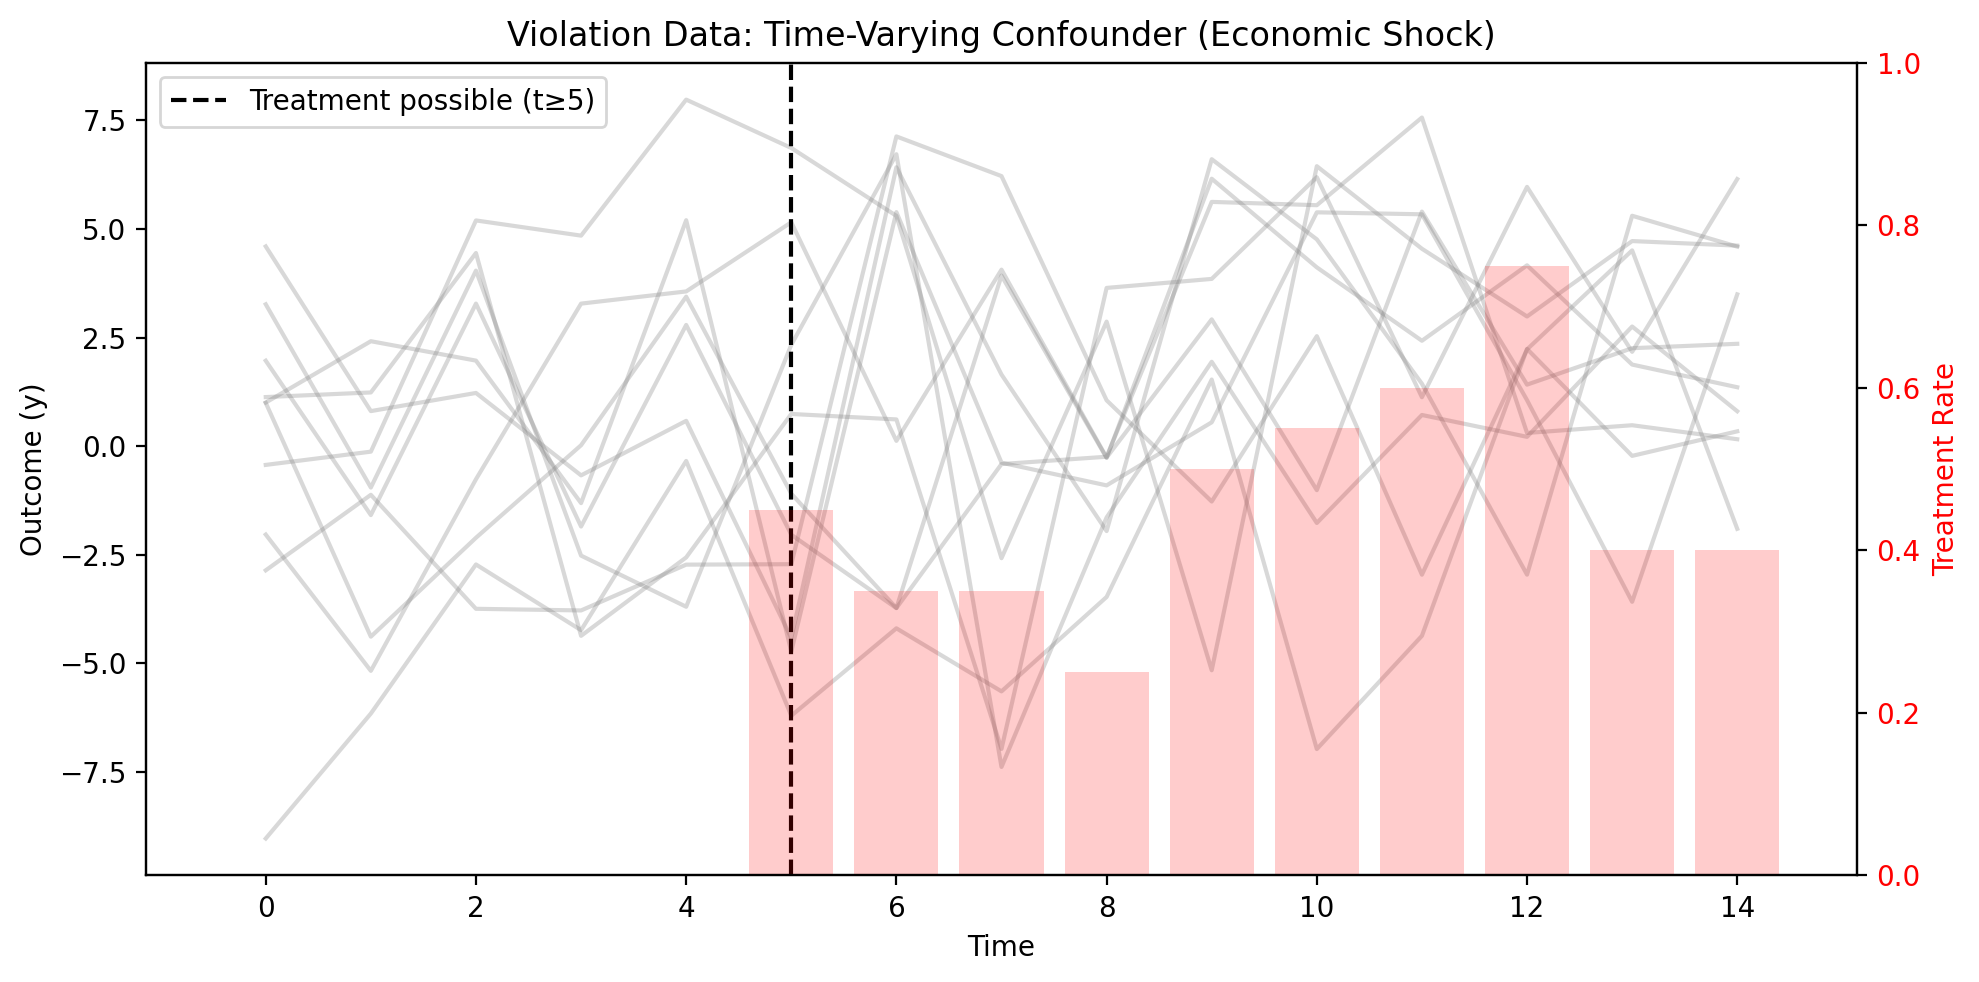

In [15]:
# Visualize the violation data
# Note: Treatment is stochastic here, so we show average treated proportion by time
fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT))

# Calculate treatment rate by time
treatment_rate = df_violation.groupby("time")["treatment"].mean()
ax2 = ax.twinx()
ax2.bar(
    treatment_rate.index,
    treatment_rate.values,
    alpha=0.2,
    color="red",
    label="Treatment rate",
)
ax2.set_ylabel("Treatment Rate", color="red")
ax2.tick_params(axis="y", labelcolor="red")
ax2.set_ylim(0, 1)

# Plot individual trajectories
for unit in df_violation["unit"].unique()[:10]:  # Sample 10 units
    unit_data = df_violation[df_violation["unit"] == unit]
    ax.plot(unit_data["time"], unit_data["y"], alpha=0.3, color="gray")

ax.axvline(x=5, color="black", linestyle="--", label="Treatment possible (t≥5)")
ax.set_xlabel("Time")
ax.set_ylabel("Outcome (y)")
ax.set_title("Violation Data: Time-Varying Confounder (Economic Shock)")
ax.legend(loc="upper left")
plt.tight_layout()

**Figure (Example 2).** Left axis: outcome $y$ by time; gray lines = unit-level trajectories. Right axis: treatment rate by period (bars). Vertical black dashed line: first period when treatment is possible ($t \geq 5$).

Units experiencing positive economic shocks are both more likely to be treated *and* have higher outcomes, creating confounding that fixed effects cannot remove.


This example demonstrates a critical limitation: **fixed effects only removes time-invariant confounders**. In DAG terms, adding a time-varying confounder $v_{it}$ creates an open backdoor path that fixed effects cannot close:


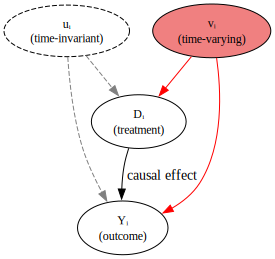

In [16]:
# DAG showing both time-invariant AND time-varying confounders
dag_violation = Digraph(comment="FE Violation DAG")
dag_violation.attr(rankdir="TB", size="7,4")
dag_violation.attr("node", shape="ellipse", fontsize="12")

# Nodes
dag_violation.node("U", "uᵢ\n(time-invariant)", style="dashed")
dag_violation.node("V", "vᵢₜ\n(time-varying)", style="filled", fillcolor="lightcoral")
dag_violation.node("D", "Dᵢₜ\n(treatment)")
dag_violation.node("Y", "Yᵢₜ\n(outcome)")

# Edges - u_i is removed by FE (crossed out conceptually)
dag_violation.edge("U", "D", style="dashed", color="gray")
dag_violation.edge("U", "Y", style="dashed", color="gray")
dag_violation.edge("V", "D", color="red")  # This path is NOT removed
dag_violation.edge("V", "Y", color="red")  # This path is NOT removed
dag_violation.edge("D", "Y", label="  causal effect")

dag_violation

Fixed effects eliminates the $u_i$ backdoor path (gray, dashed) but **not** the $v_{it}$ path (red). The estimate remains biased.

:::{important}
Before using fixed effects, ask yourself: *Are there any unobserved factors that change over time and affect both my treatment and outcome?* If yes, fixed effects alone is insufficient.
:::


## Connection to Difference-in-Differences

Two-way fixed effects (TWFE) - with both unit and time fixed effects - is closely related to difference-in-differences (DiD).

With a simple 2x2 design (2 groups, 2 periods, binary treatment), TWFE produces **numerically identical** estimates to the classic DiD estimator. The model:

$$Y_{it} = \alpha_i + \gamma_t + \beta \cdot D_{it} + \epsilon_{it}$$

where:
- $\alpha_i$ = unit fixed effects
- $\gamma_t$ = time fixed effects
- $D_{it}$ = treatment indicator

is a workhorse of applied causal inference. The coefficient $\beta$ captures the treatment effect.

With more complex designs (staggered treatment adoption, heterogeneous effects), TWFE and simple DiD can diverge. Recent econometrics research {cite:p}`goodman2021difference,dechaisemartin2020twfe` has highlighted that TWFE can give misleading results when:

1. **Treatment effects vary over time** (dynamic effects)
2. **Treatment rolls out at different times** (staggered adoption)
3. **Treatment effects differ across units** (heterogeneity)

For these cases, consider using CausalPy's `DifferenceInDifferences` class or newer estimators designed for staggered designs.

:::{seealso}
See the [Difference-in-Differences notebook](did_pymc.ipynb) for more on DiD methods in CausalPy.
:::


## Example 3: Two-Way Fixed Effects (Unit + Time)

When both unit and time confounders matter, we use **two-way** fixed effects. This example illustrates that with state-level policy data.

Two-way fixed effects (TWFE) is the workhorse model in applied economics and the foundation of difference-in-differences analysis.

**Causal Question:** What is the effect of a state policy on outcomes, controlling for both state-specific factors and common time trends?

This example uses **two-way fixed effects** (state + year FE), which controls for:
- Time-invariant state characteristics (state FE) — e.g., geography, political culture
- Common shocks affecting all states in a given year (year FE) — e.g., national economic conditions

**When to use two-way FE:**
- Treatment timing varies across units (staggered adoption)
- Common time shocks could confound the treatment-outcome relationship
- You're doing a difference-in-differences style analysis

For small panels (e.g., 50 US states), we can use the dummy variable approach.

In [17]:
# Simulate state-level data
rng = np.random.default_rng(123)

n_states = 12
n_years = 10
policy_year = 5

state_data = []
for s in range(n_states):
    state_name = f"State_{chr(65 + s)}"
    state_baseline = rng.normal(loc=50, scale=5)

    for y in range(n_years):
        policy = 1 if (y >= policy_year and s < n_states // 2) else 0
        gdp_growth = rng.normal(scale=2)

        outcome = (
            state_baseline
            + 0.3 * y
            + 5.0 * policy
            + 0.5 * gdp_growth
            + rng.normal(scale=1.5)
        )

        state_data.append(
            {
                "state": state_name,
                "year": y,
                "policy": policy,
                "gdp_growth": gdp_growth,
                "outcome": outcome,
            }
        )

df_states = pd.DataFrame(state_data)
print(f"State panel: {n_states} states, {n_years} years")
df_states.head()

State panel: 12 states, 10 years


,state,year,policy,gdp_growth,outcome
0,State_A,0,0,-0.735573,46.618494
1,State_A,1,0,0.387949,46.928714
2,State_A,2,0,1.154208,45.276802
3,State_A,3,0,1.083904,46.021452
4,State_A,4,0,-0.644778,46.077755


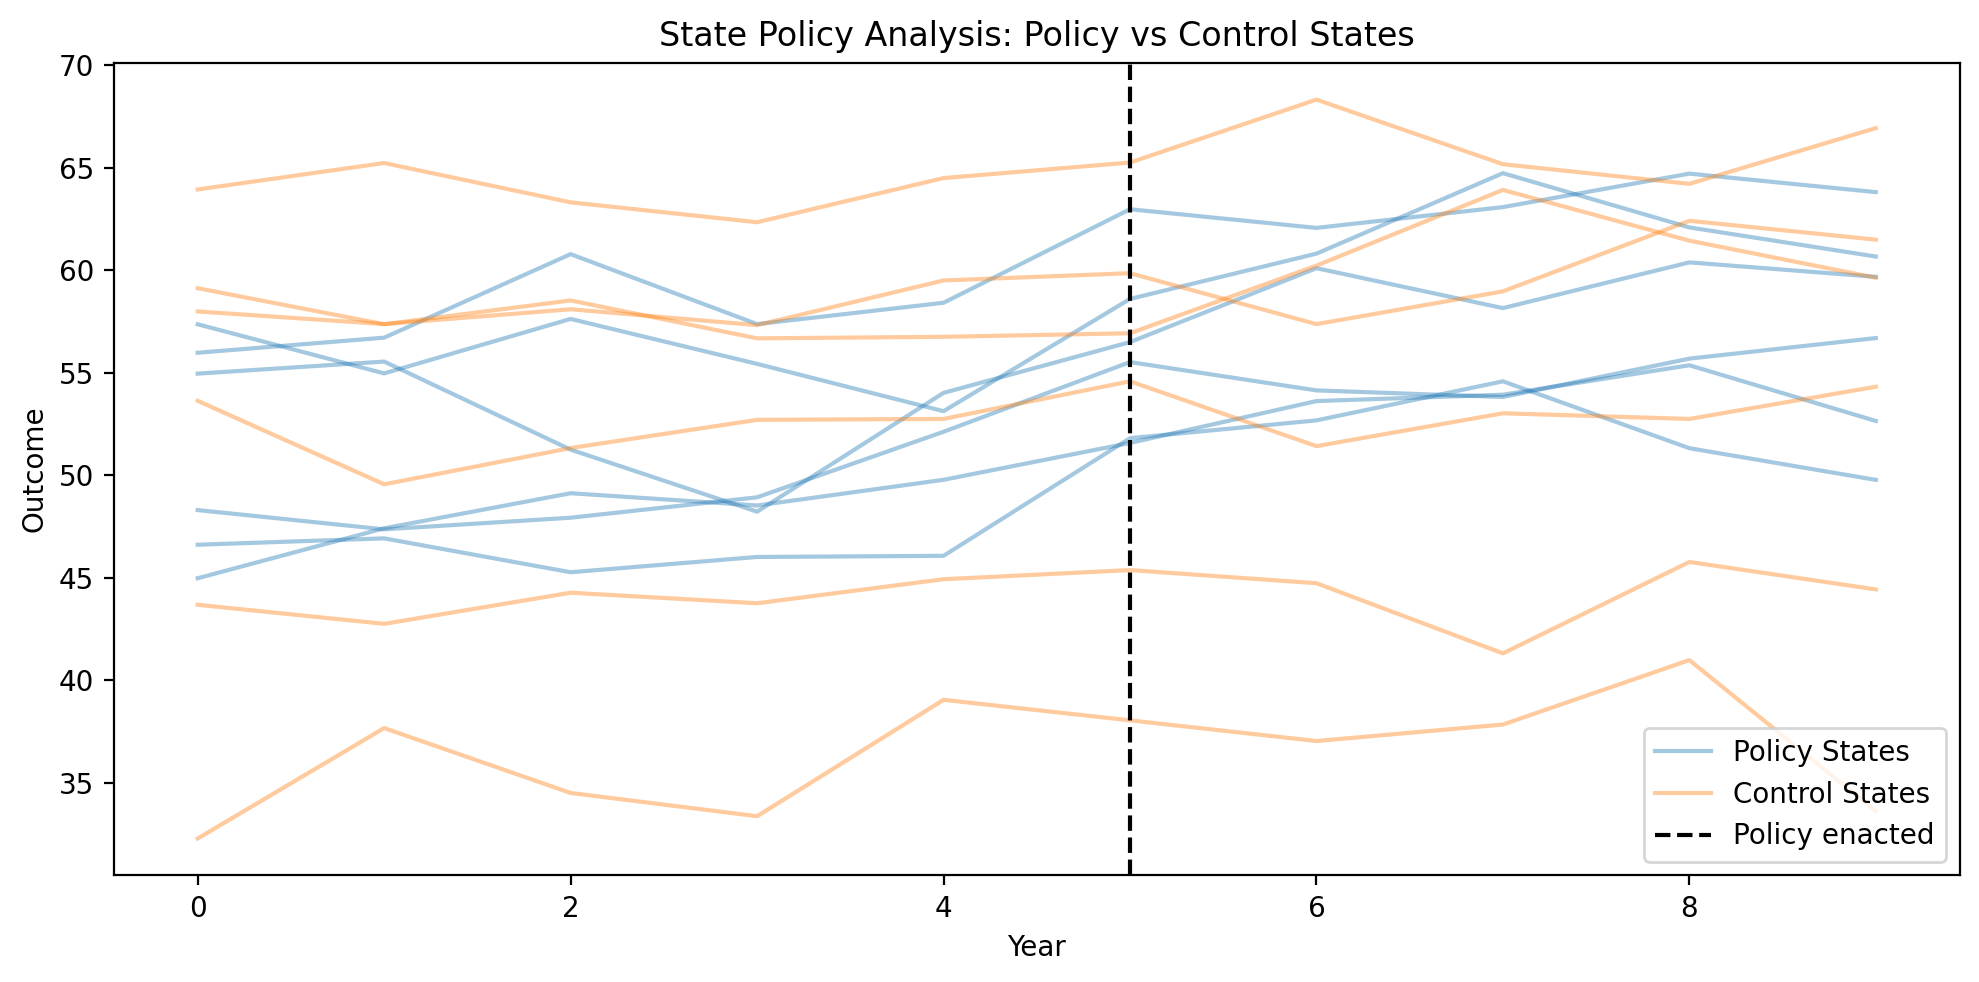

In [18]:
# Visualize state policy data
fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT))

# Add treatment group indicator (states A-F get policy, G-L don't)
df_states["group"] = df_states["state"].apply(
    lambda x: "Policy States" if ord(x.split("_")[1]) - 65 < 6 else "Control States"
)

sns.lineplot(
    data=df_states,
    x="year",
    y="outcome",
    hue="group",
    units="state",
    estimator=None,
    alpha=0.4,
    ax=ax,
)
ax.axvline(x=policy_year, color="black", linestyle="--", label="Policy enacted")
ax.set_xlabel("Year")
ax.set_ylabel("Outcome")
ax.set_title("State Policy Analysis: Policy vs Control States")
ax.legend()
plt.tight_layout()

**Figure (Example 3).** Outcome by year; one line per state, grouped by policy vs control. Vertical black dashed line: policy enactment year. Aggregation by group (policy vs control states).

In [19]:
# Fit panel regression with state and year FE (Bayesian)
result_states = cp.PanelRegression(
    data=df_states,
    formula="outcome ~ C(state) + C(year) + policy + gdp_growth",
    unit_fe_variable="state",
    time_fe_variable="year",
    fe_method="dummies",
    model=cp.pymc_models.LinearRegression(sample_kwargs=sample_kwargs),
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]


In [20]:
result_states.summary()


Panel Regression
Units: 12 (state)
Periods: 10 (year)
FE method: dummies
Observations: 120

Note: 20 fixed effect coefficients not shown (use print_coefficients() to see all)

Model Coefficients:
Model coefficients:
    Intercept    46, 94% HDI [45, 48]
    policy       3.9, 94% HDI [2.9, 5]
    gdp_growth   0.48, 94% HDI [0.33, 0.63]
    y_hat_sigma  1.5, 94% HDI [1.3, 1.7]


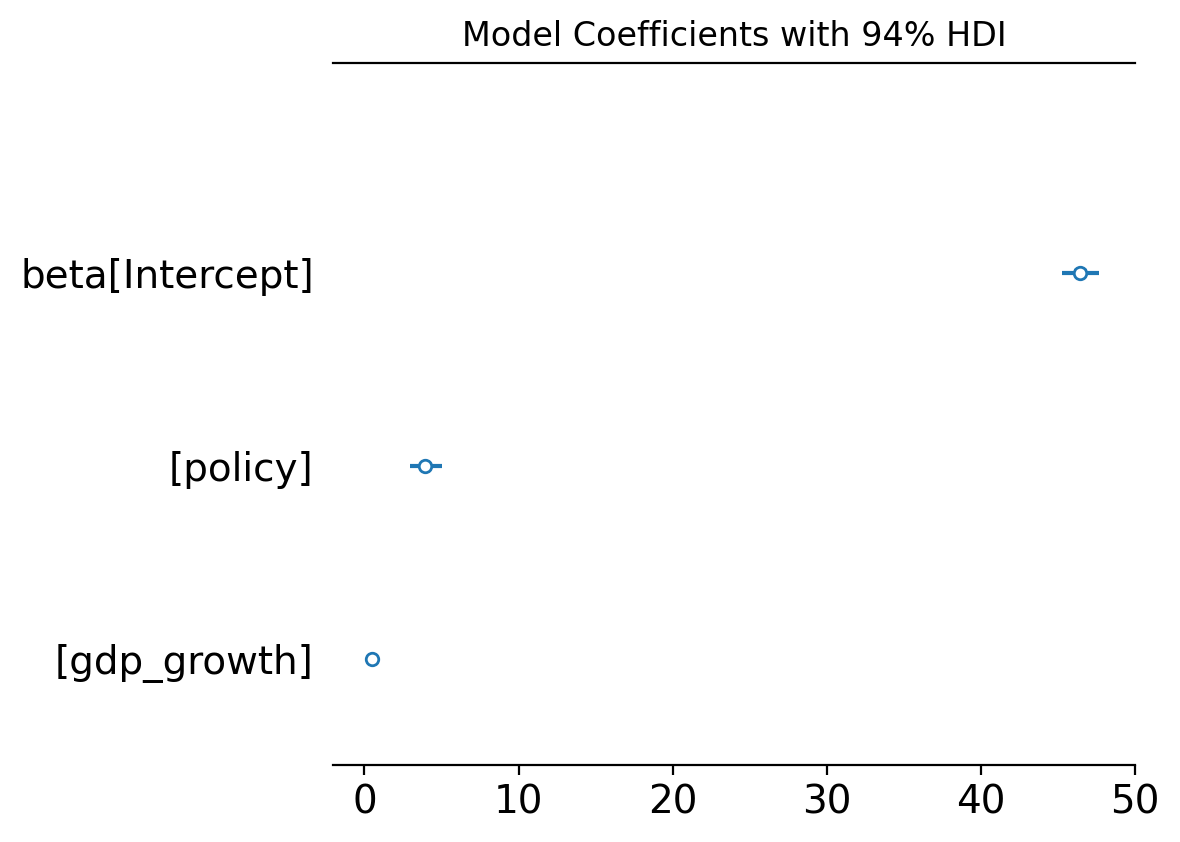

In [21]:
# Coefficient plot
fig, ax = result_states.plot_coefficients()
plt.tight_layout()
plt.show()

**Figure (coefficients).** Posterior distributions of model coefficients (policy, gdp_growth, etc.) with 94% HDI. The treatment effect of interest is the *policy* coefficient.

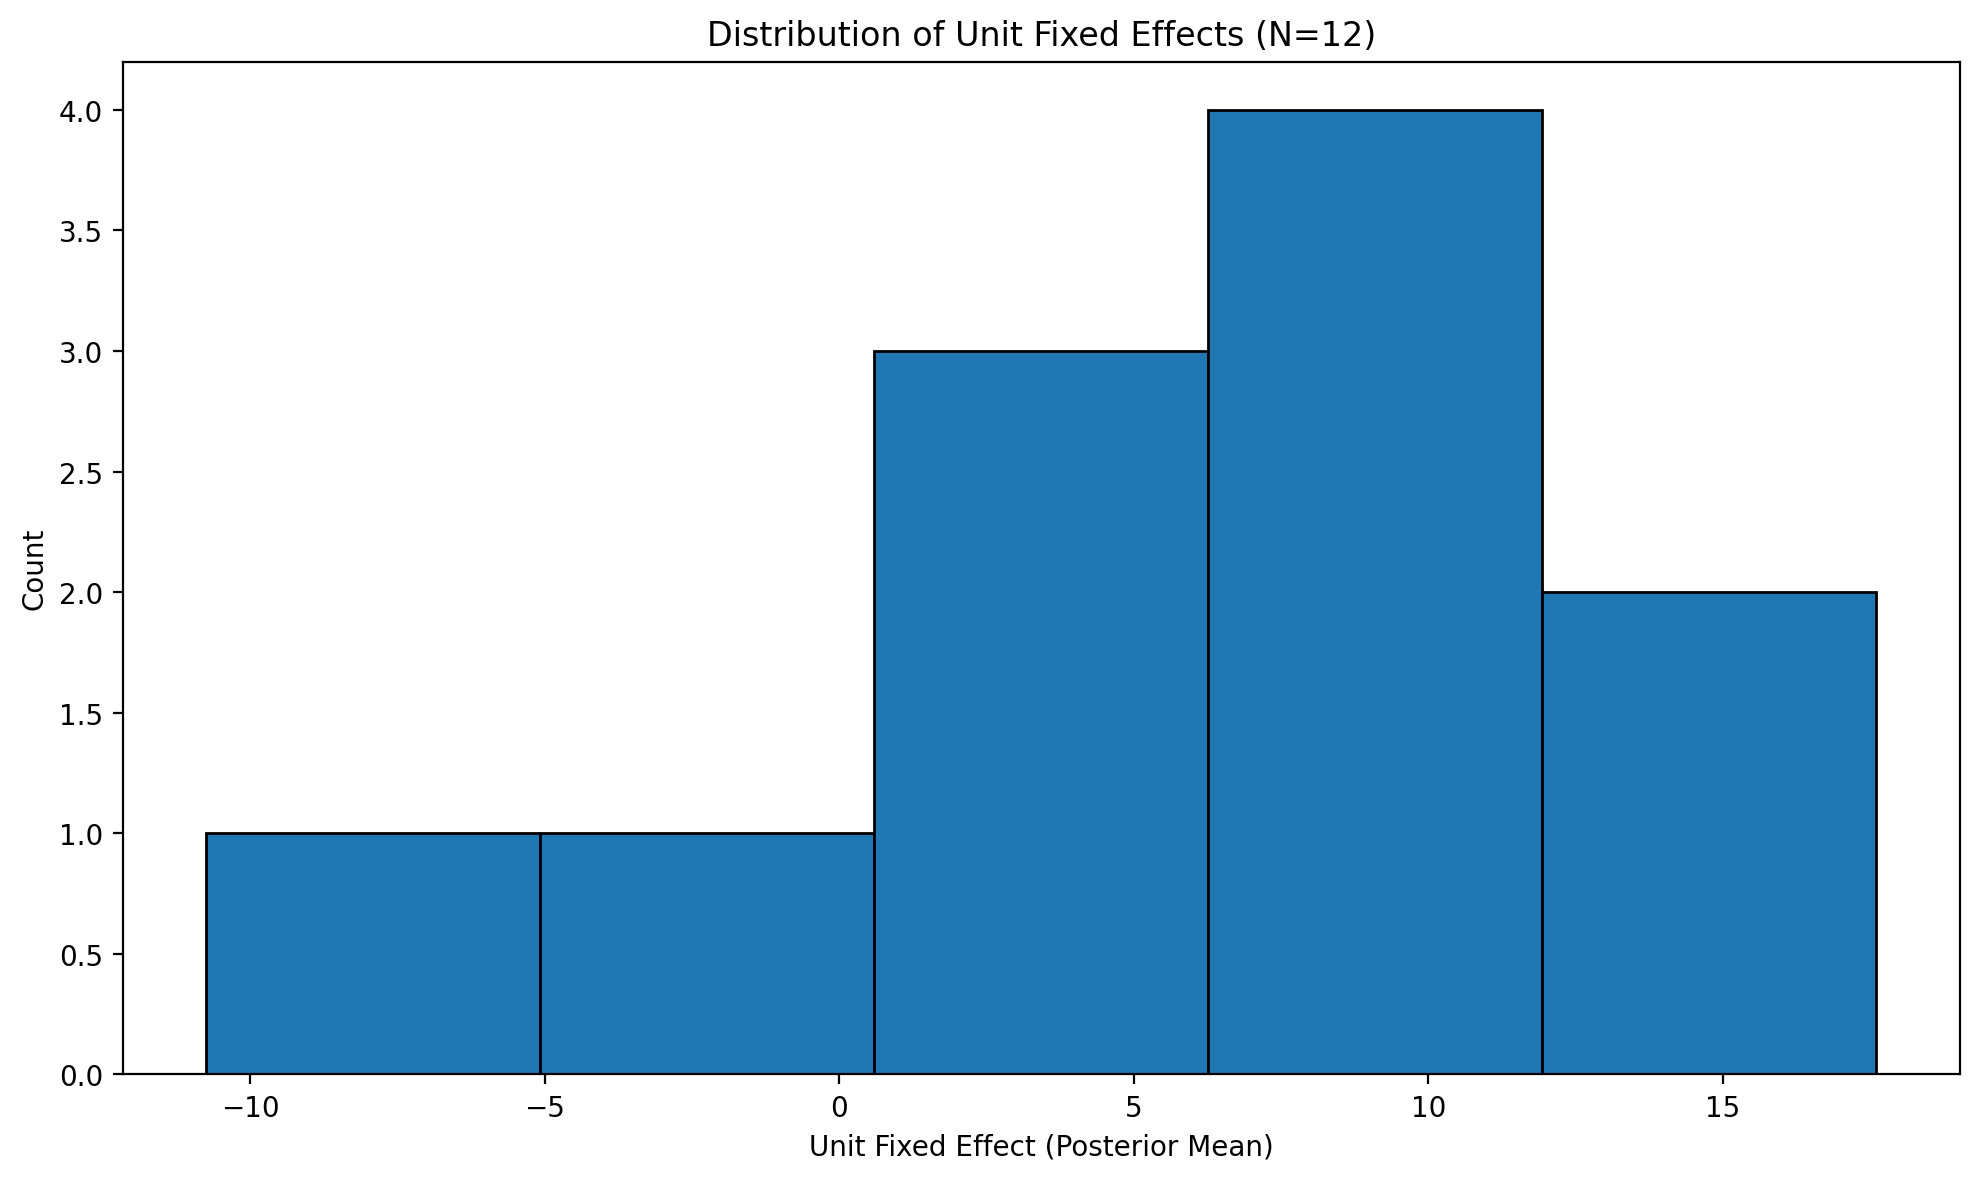

In [22]:
# Distribution of state fixed effects
fig, ax = result_states.plot_unit_effects()
plt.tight_layout()
plt.show()

**Figure (unit effects).** Estimated unit (state) fixed effects: distribution of state-specific intercepts from the two-way FE model.

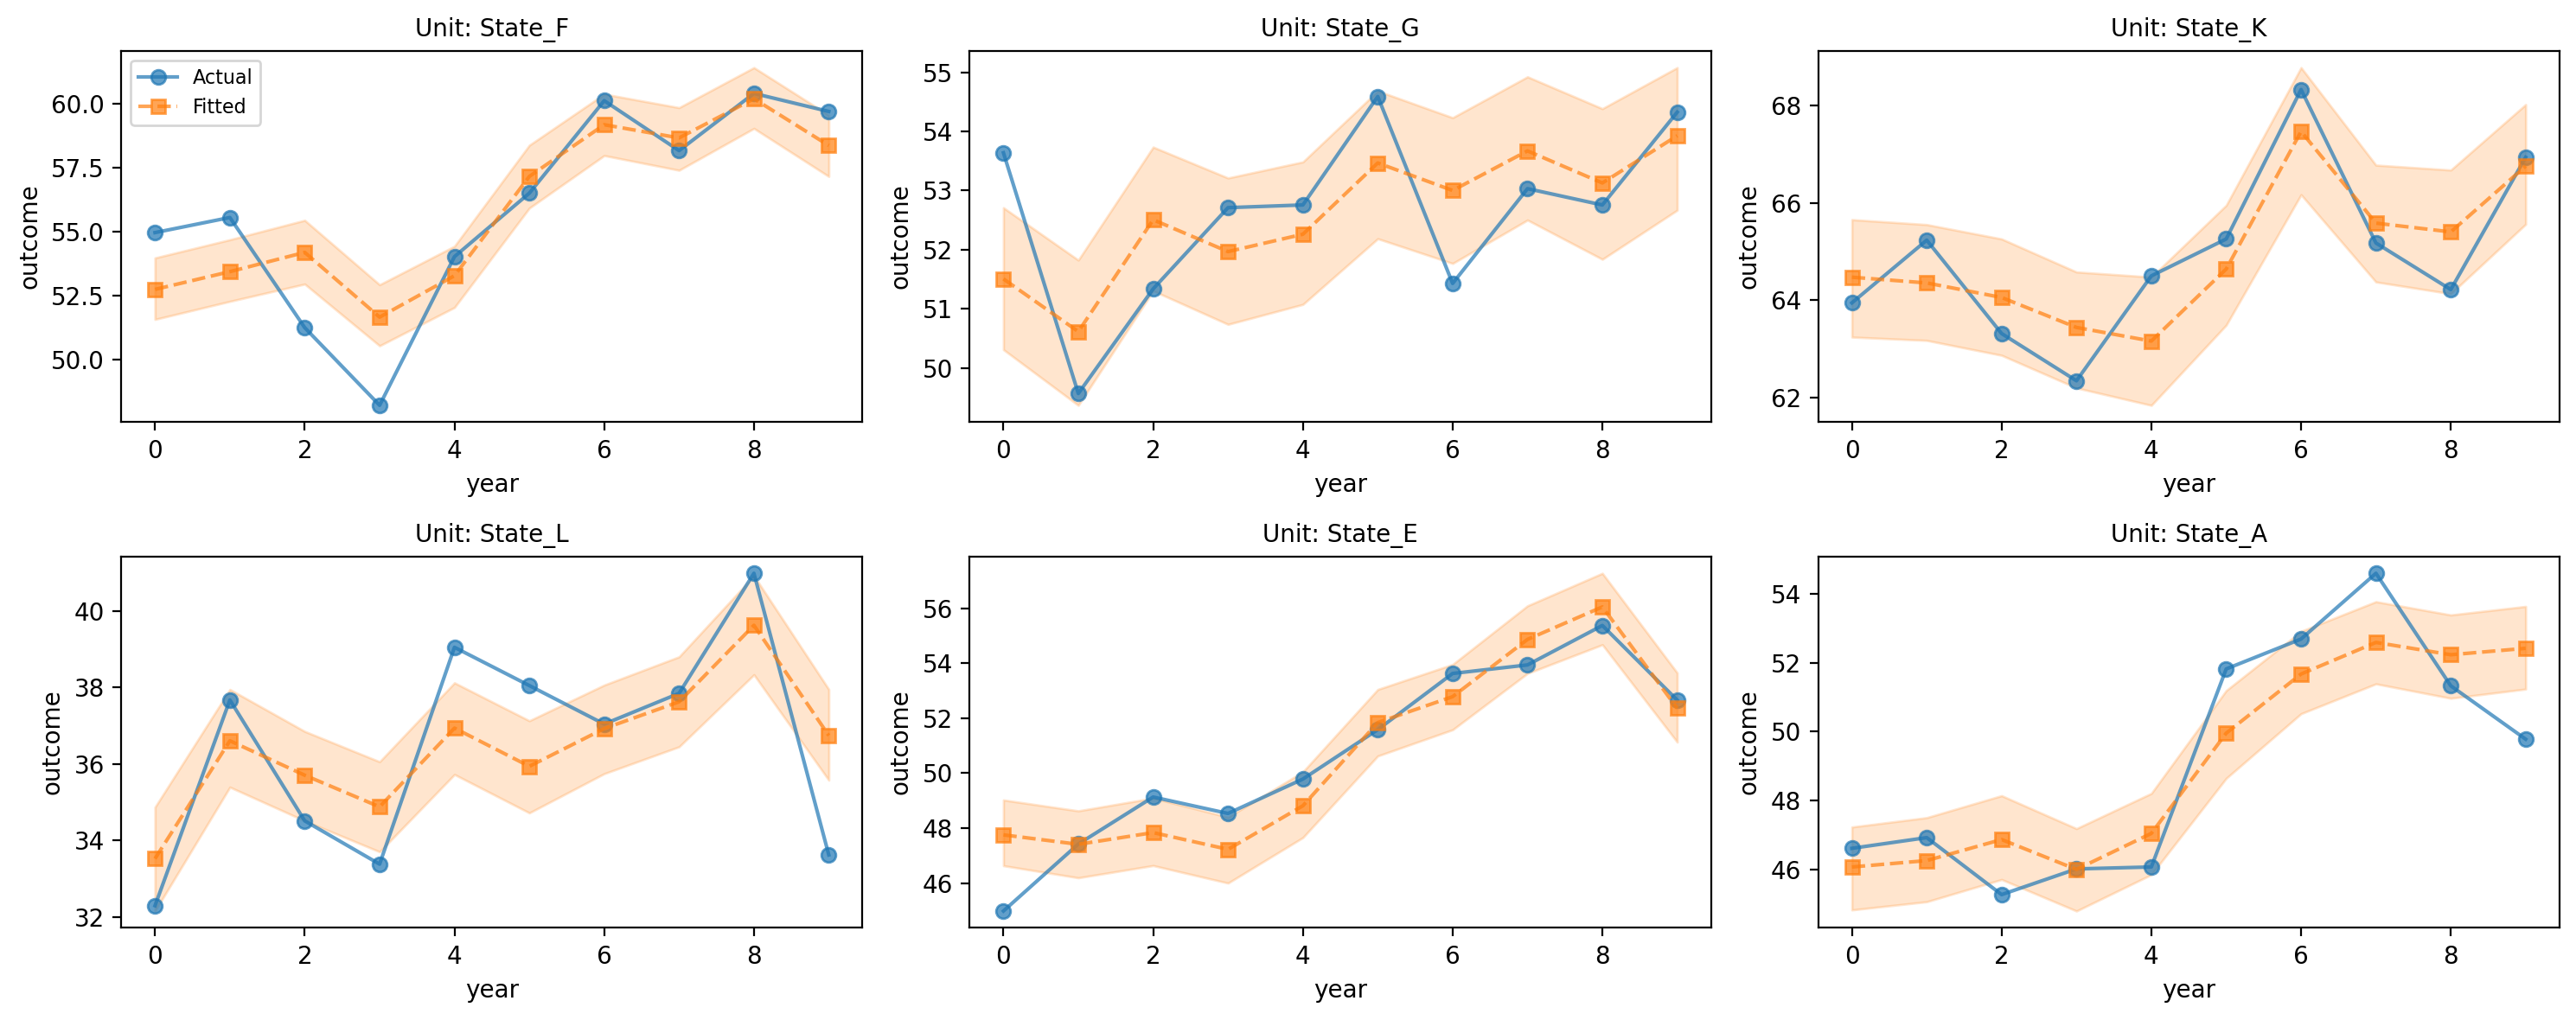

In [23]:
# State trajectories
fig, axes = result_states.plot_trajectories(n_sample=6)
plt.tight_layout()
plt.show()

**Figure (trajectories).** Sample of state-level outcome trajectories; observed vs model (two-way FE). Used to assess fit and heterogeneity across units.

## Example 4: Two-Way FE with Large Panel (Demeaned Transformation)

With many units, dummy variables don't scale. We switch to the **demeaned** transformation and illustrate with a worker panel.

With 200 workers, including dummy variables for each would add 199 coefficients to our model—slow to estimate and cluttering output with nuisance parameters we don't care about. The **demeaned transformation** solves this by subtracting group means before estimation, effectively sweeping out the fixed effects without explicitly estimating them.

**Causal Question:** What is the effect of job training on worker productivity?

This is our motivating example from the introduction! Workers who receive training may differ in unobserved ability - the classic selection problem.

**Why two-way FE here?**
- **Worker FE:** Controls for innate ability (time-invariant)
- **Wave FE:** Controls for economy-wide conditions affecting all workers

**Assumptions we're making:**
- Innate ability is time-invariant (plausible)
- No time-varying confounders (e.g., no unobserved motivation shocks)
- Training doesn't respond to recent productivity changes

In [24]:
# Simulate worker panel
rng = np.random.default_rng(456)

n_workers = 200
n_waves = 8
training_wave = 4

worker_data = []
for w in range(n_workers):
    worker_id = f"worker_{w:04d}"
    ability = rng.normal(scale=3)

    for wave in range(n_waves):
        trained = 1 if (wave >= training_wave and w < n_workers * 0.4) else 0
        experience = wave * 0.5 + rng.normal(scale=0.2)

        productivity = (
            ability + 2.5 * trained + 0.3 * experience + rng.normal(scale=0.8)
        )

        worker_data.append(
            {
                "worker_id": worker_id,
                "wave": wave,
                "trained": trained,
                "experience": experience,
                "productivity": productivity,
            }
        )

df_workers = pd.DataFrame(worker_data)
print(f"Worker panel: {n_workers} workers, {n_waves} waves")
df_workers.head()

Worker panel: 200 workers, 8 waves


,worker_id,wave,trained,experience,productivity
0,worker_0000,0,0,-0.424790,3.872846
1,worker_0000,1,0,0.492939,0.753789
2,worker_0000,2,0,0.961987,2.445428
3,worker_0000,3,0,1.417059,2.879282
4,worker_0000,4,1,2.389001,6.709637


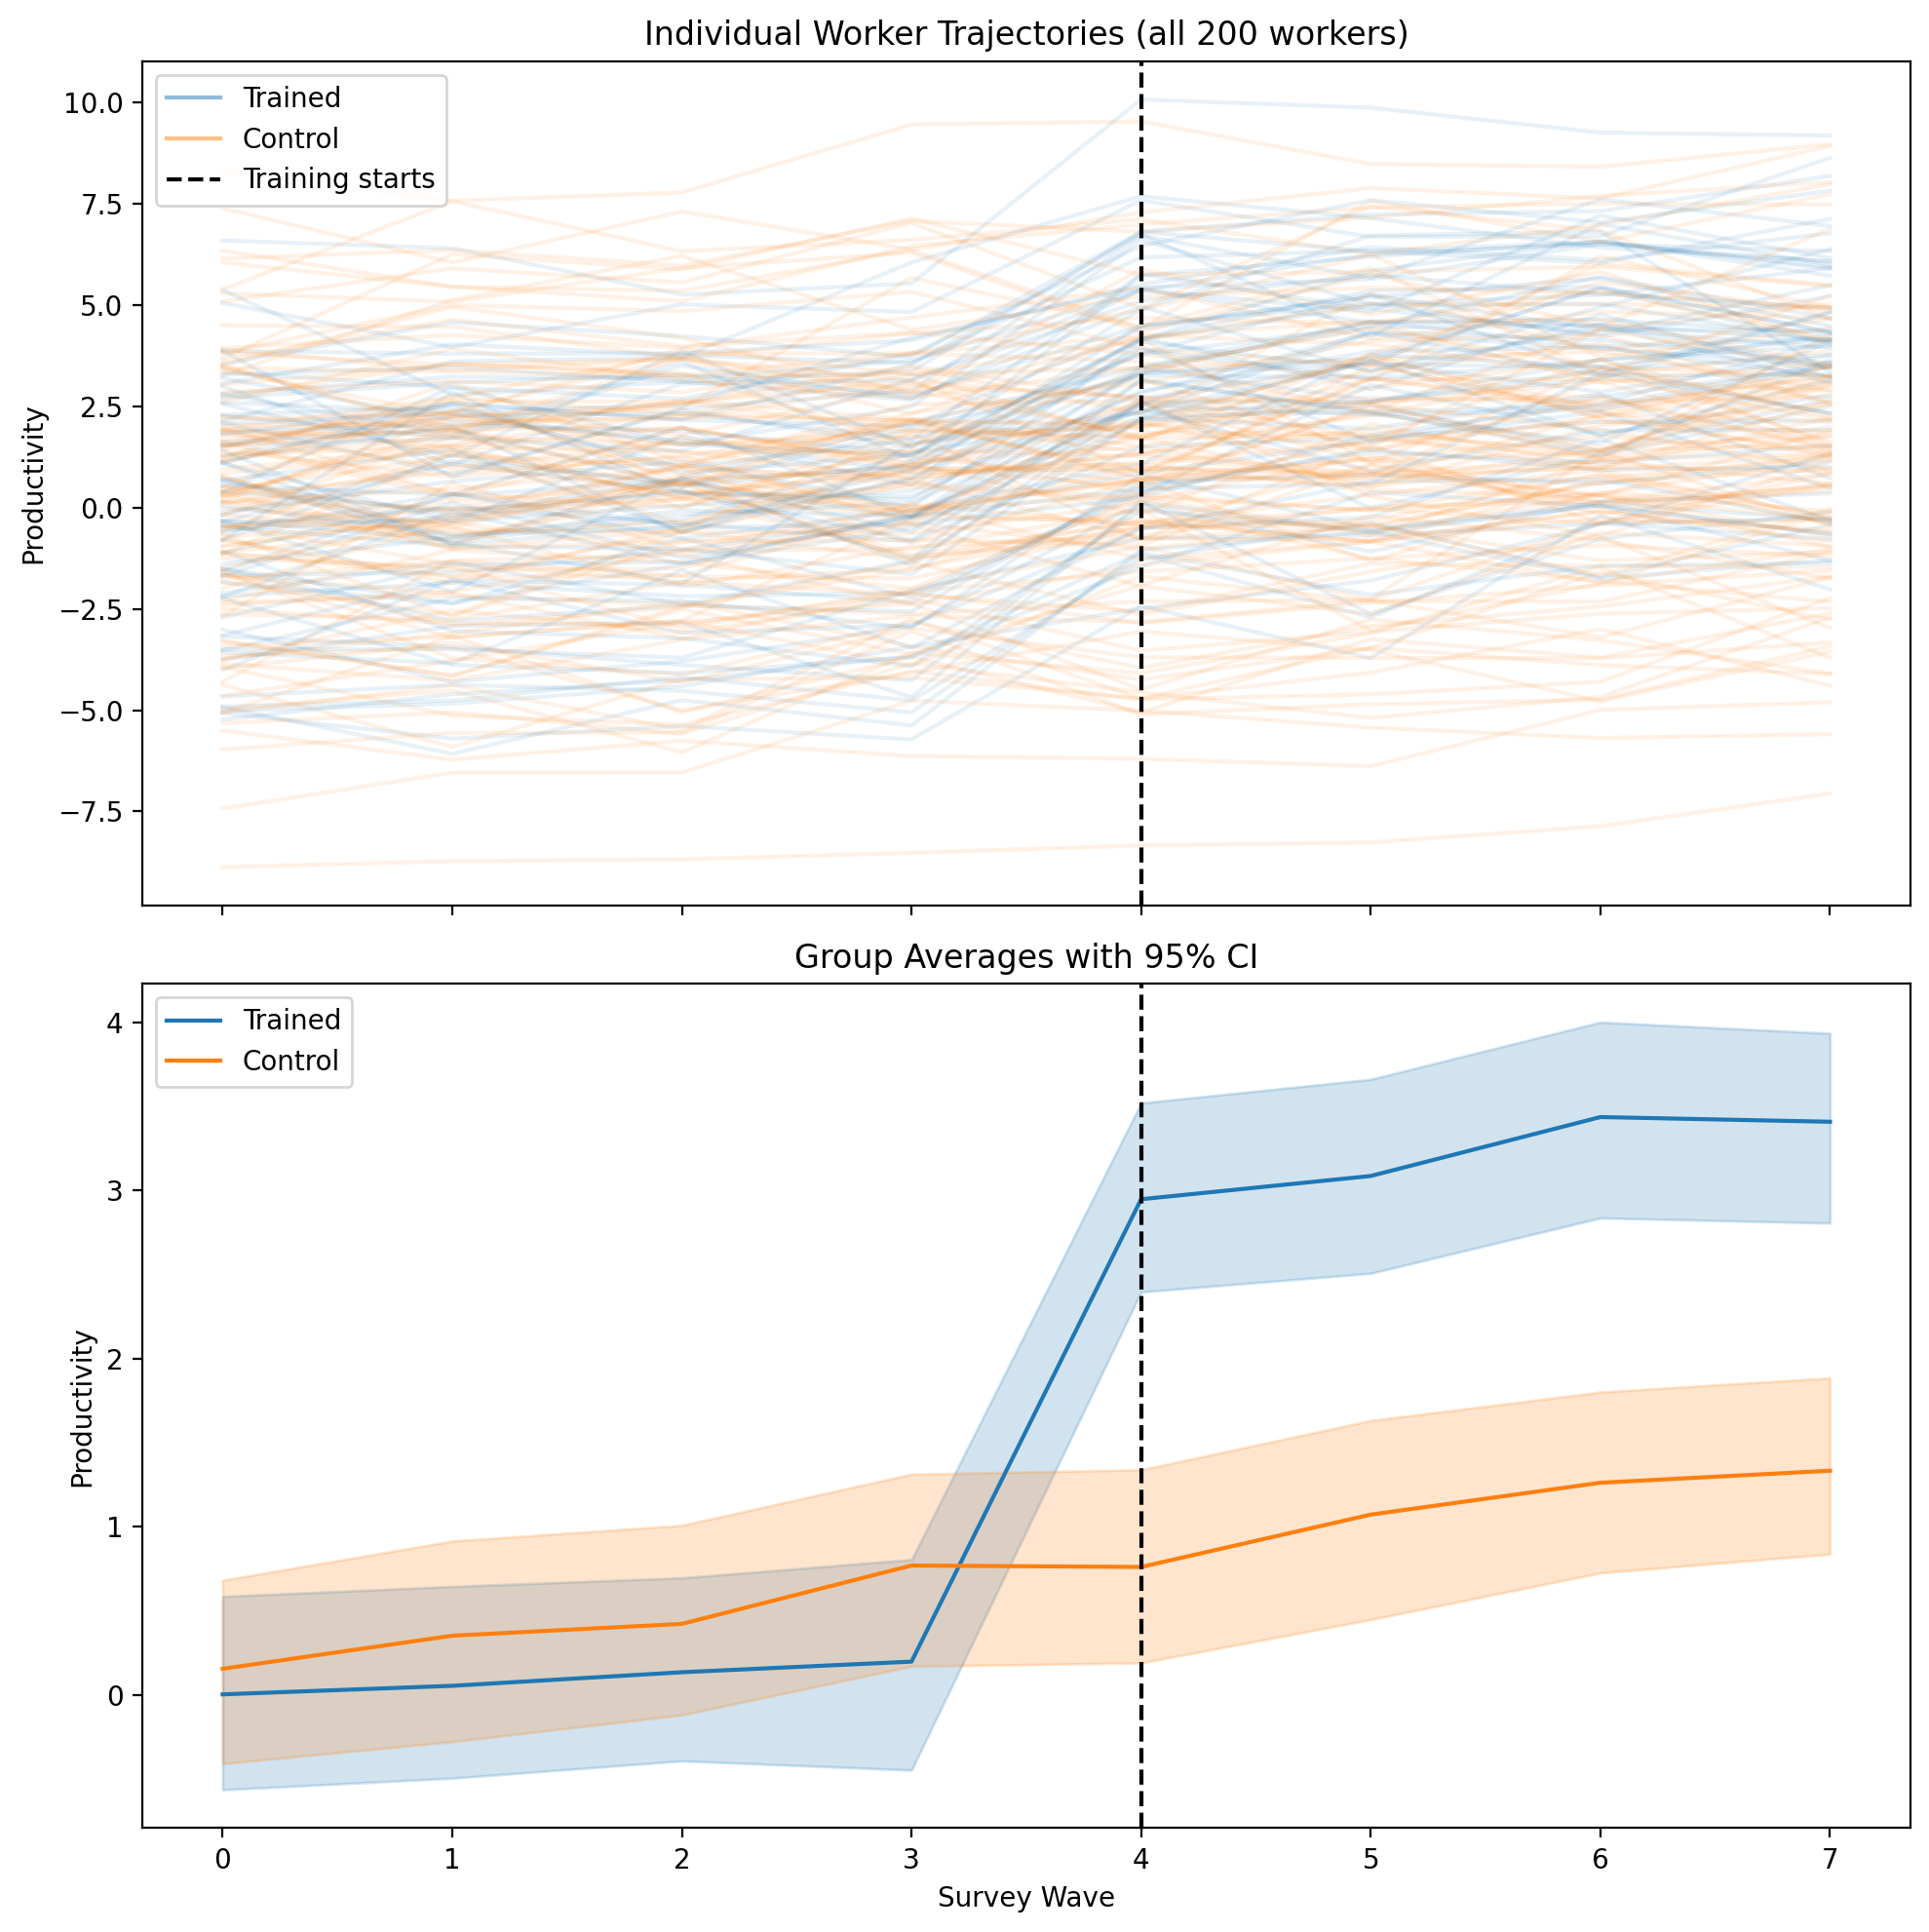

In [25]:
# Visualize worker training data
fig, axes = plt.subplots(2, 1, figsize=(FIG_WIDTH, 2 * FIG_HEIGHT), sharex=True)

# Add treatment group indicator (first 40% = workers 0-79 are trained)
df_workers["group"] = df_workers["worker_id"].apply(
    lambda x: "Trained" if int(x.split("_")[1]) < 80 else "Control"
)

# Top panel: Individual trajectories (all workers)
ax1 = axes[0]
for group, color in [("Trained", "C0"), ("Control", "C1")]:
    group_data = df_workers[df_workers["group"] == group]
    for worker in group_data["worker_id"].unique():
        worker_data = group_data[group_data["worker_id"] == worker]
        ax1.plot(
            worker_data["wave"], worker_data["productivity"], alpha=0.1, color=color
        )
# Add legend manually
ax1.plot([], [], color="C0", alpha=0.5, label="Trained")
ax1.plot([], [], color="C1", alpha=0.5, label="Control")
ax1.axvline(x=training_wave, color="black", linestyle="--", label="Training starts")
ax1.set_ylabel("Productivity")
ax1.set_title("Individual Worker Trajectories (all 200 workers)")
ax1.legend(loc="upper left")

# Bottom panel: Aggregated with CI
ax2 = axes[1]
sns.lineplot(
    data=df_workers,
    x="wave",
    y="productivity",
    hue="group",
    errorbar=("ci", 95),
    ax=ax2,
)
ax2.axvline(x=training_wave, color="black", linestyle="--")
ax2.set_xlabel("Survey Wave")
ax2.set_ylabel("Productivity")
ax2.set_title("Group Averages with 95% CI")
ax2.legend(loc="upper left")

plt.tight_layout()

**Figure (Example 4).** Top: productivity by survey wave, one line per worker (trained vs control). Bottom: group means with 95% CI. Vertical black dashed line: wave when training starts.

In [26]:
# Two-way FE with demeaned transformation (Bayesian)
# Both worker_id and wave are used for fixed effects
result_workers = cp.PanelRegression(
    data=df_workers,
    formula="productivity ~ trained + experience",
    unit_fe_variable="worker_id",  # Worker FE
    time_fe_variable="wave",  # Time FE (survey waves)
    fe_method="demeaned",
    model=cp.pymc_models.LinearRegression(sample_kwargs=sample_kwargs),
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]


In [27]:
result_workers.summary()


Panel Regression
Units: 200 (worker_id)
Periods: 8 (wave)
FE method: demeaned
Observations: 1600

Model Coefficients:
Model coefficients:
    Intercept    0.00013, 94% HDI [-0.034, 0.034]
    trained      2.4, 94% HDI [2.3, 2.6]
    experience   0.29, 94% HDI [0.11, 0.47]
    y_hat_sigma  0.73, 94% HDI [0.71, 0.76]


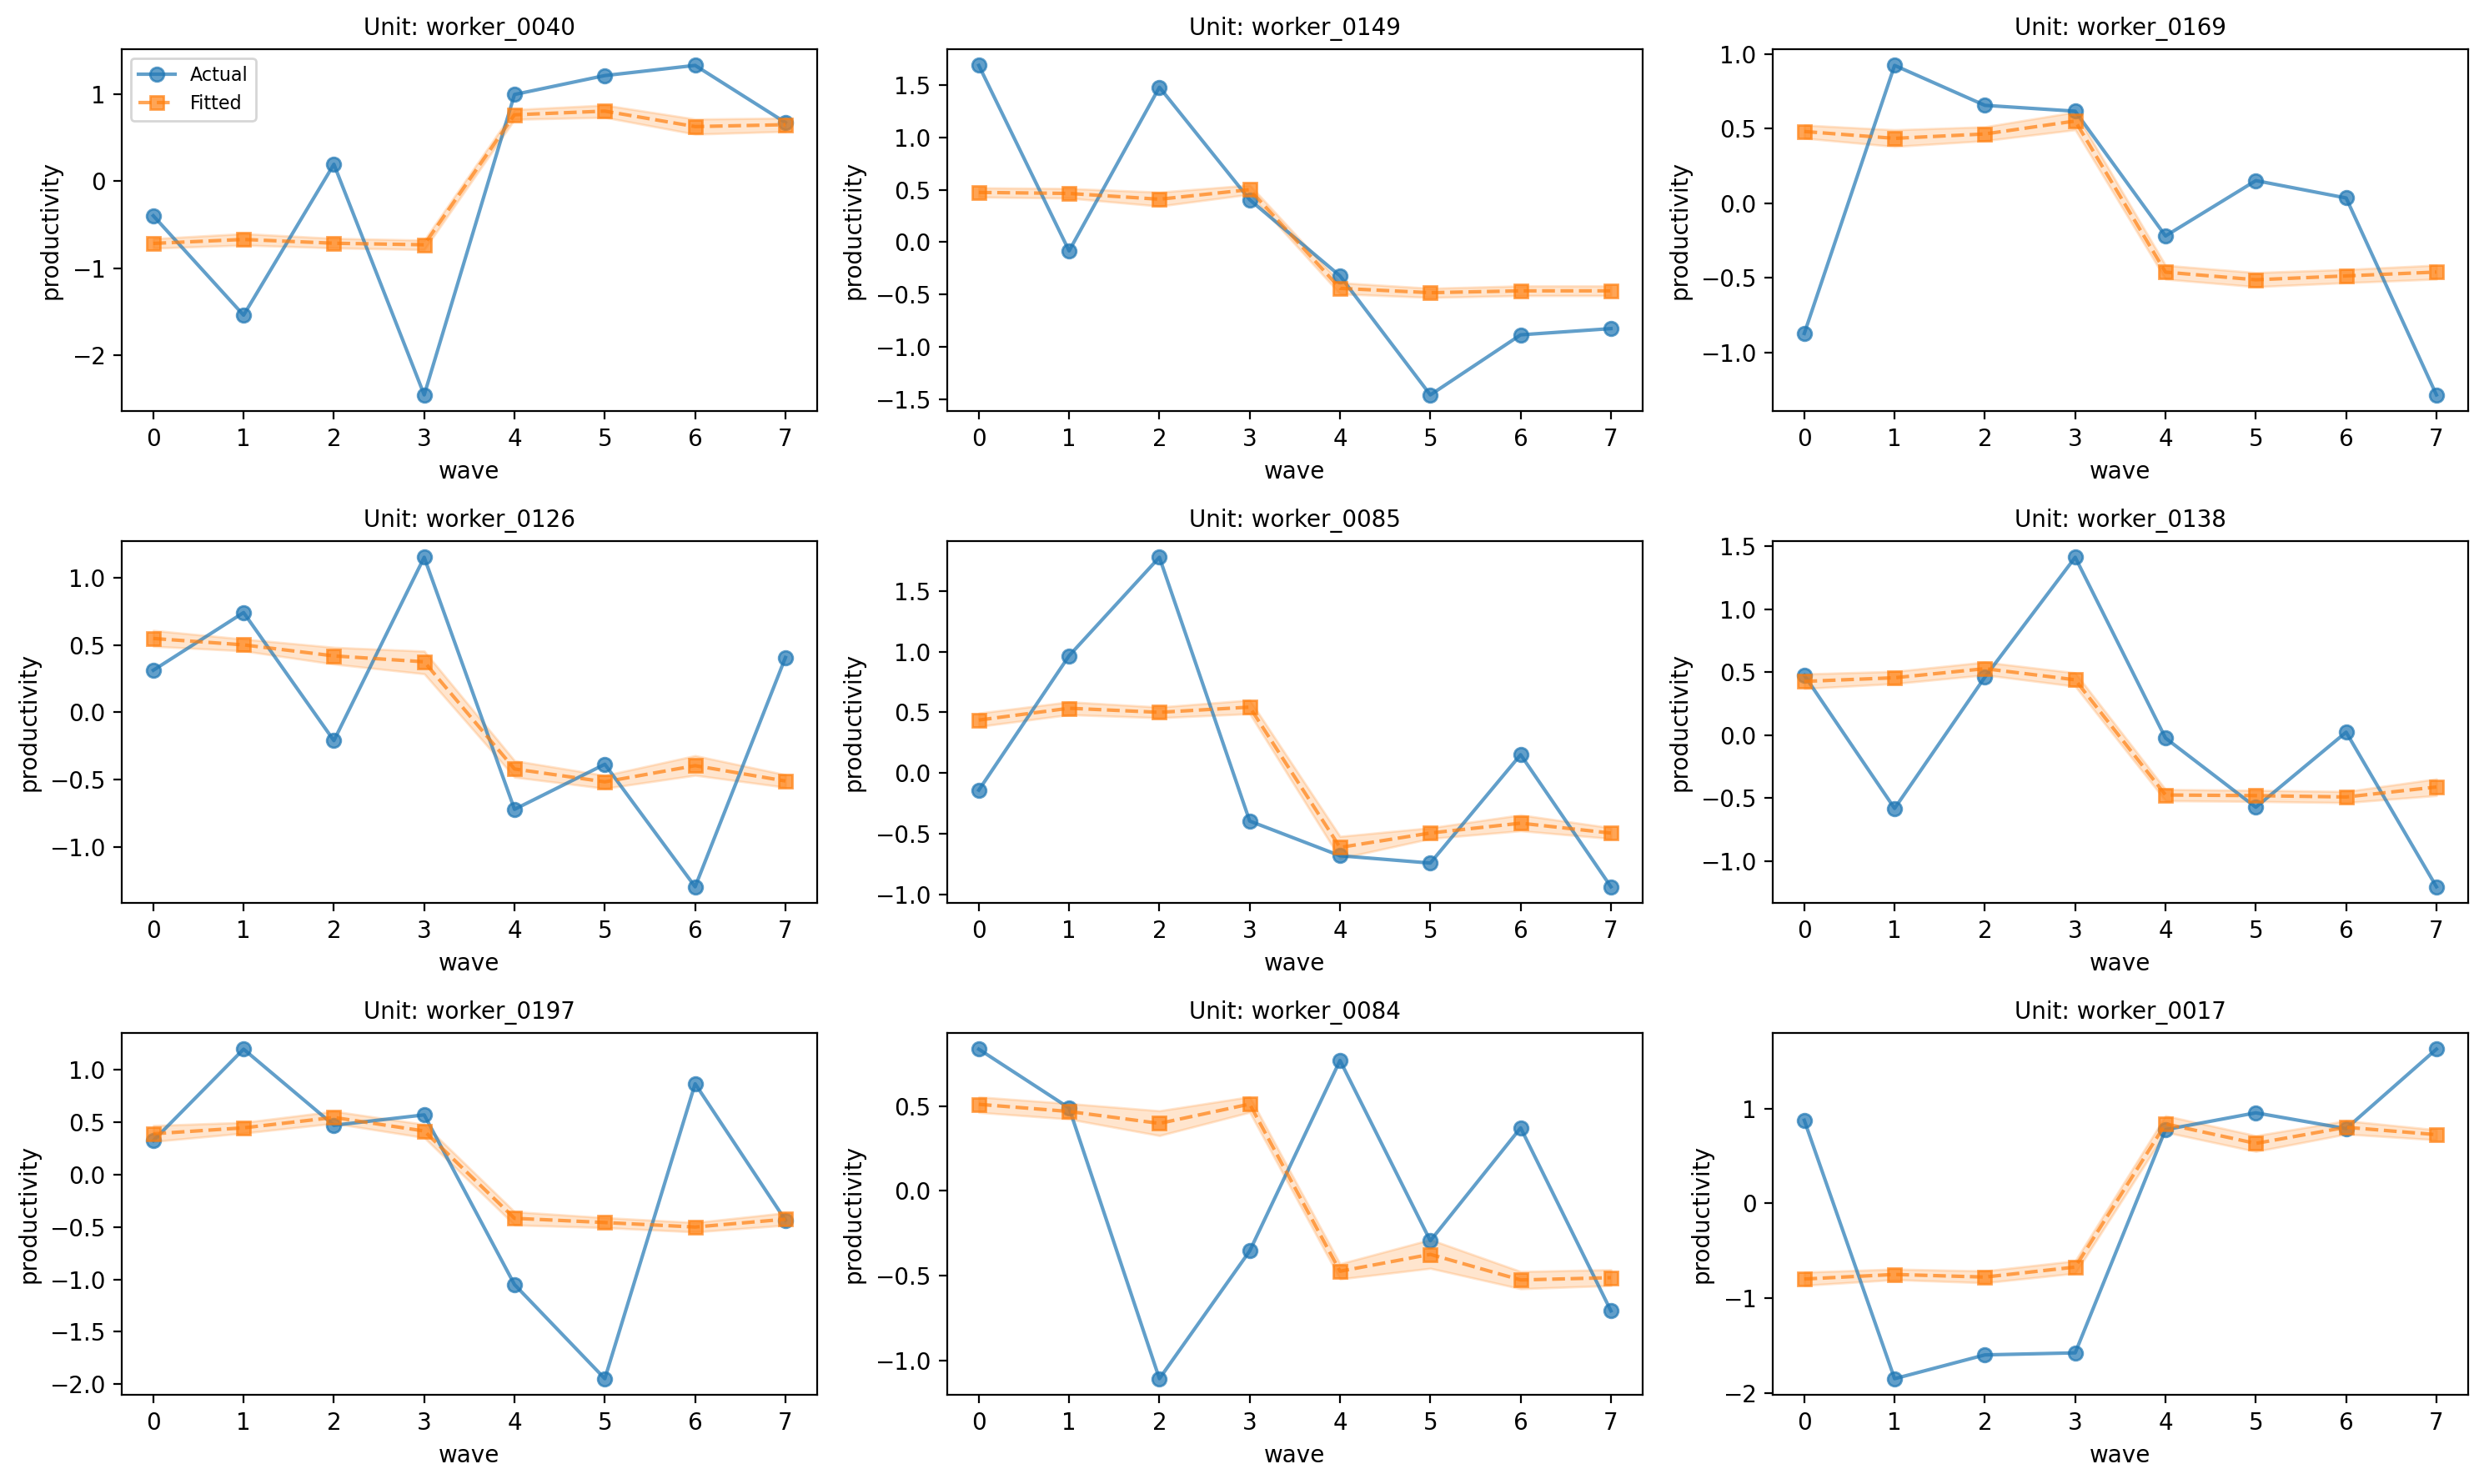

In [28]:
# Worker trajectories
fig, axes = result_workers.plot_trajectories(n_sample=9)
plt.tight_layout()
plt.show()

**Figure (worker trajectories).** Sample of worker-level productivity trajectories from the two-way FE model; observed vs predicted.

Let's check some model diagnostics.

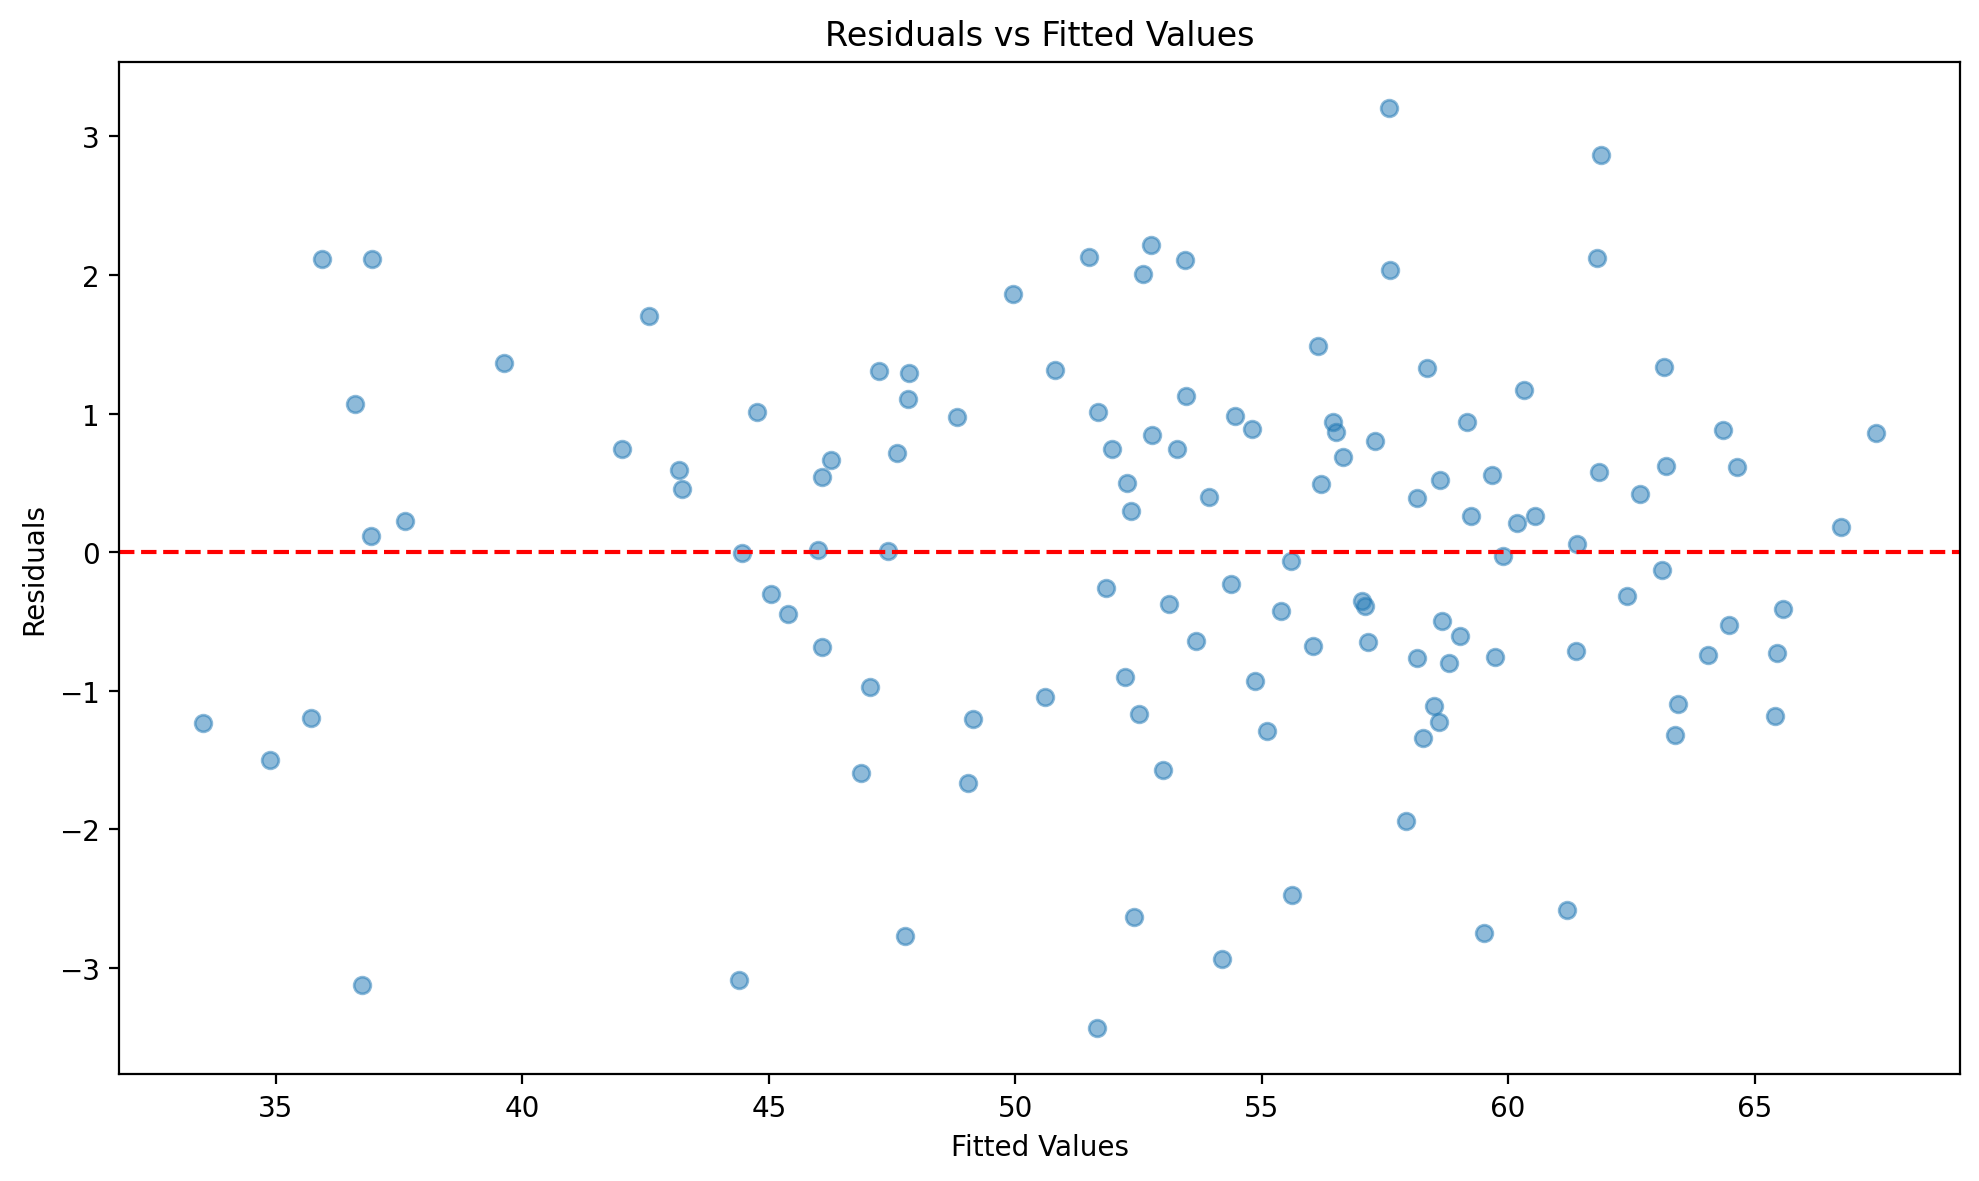

In [29]:
# Residuals vs fitted
fig, ax = result_states.plot_residuals(kind="scatter")
plt.tight_layout()
plt.show()

**Figure (residuals vs fitted).** Residuals from the state two-way FE model plotted against fitted values; used to check homoscedasticity and pattern in errors.

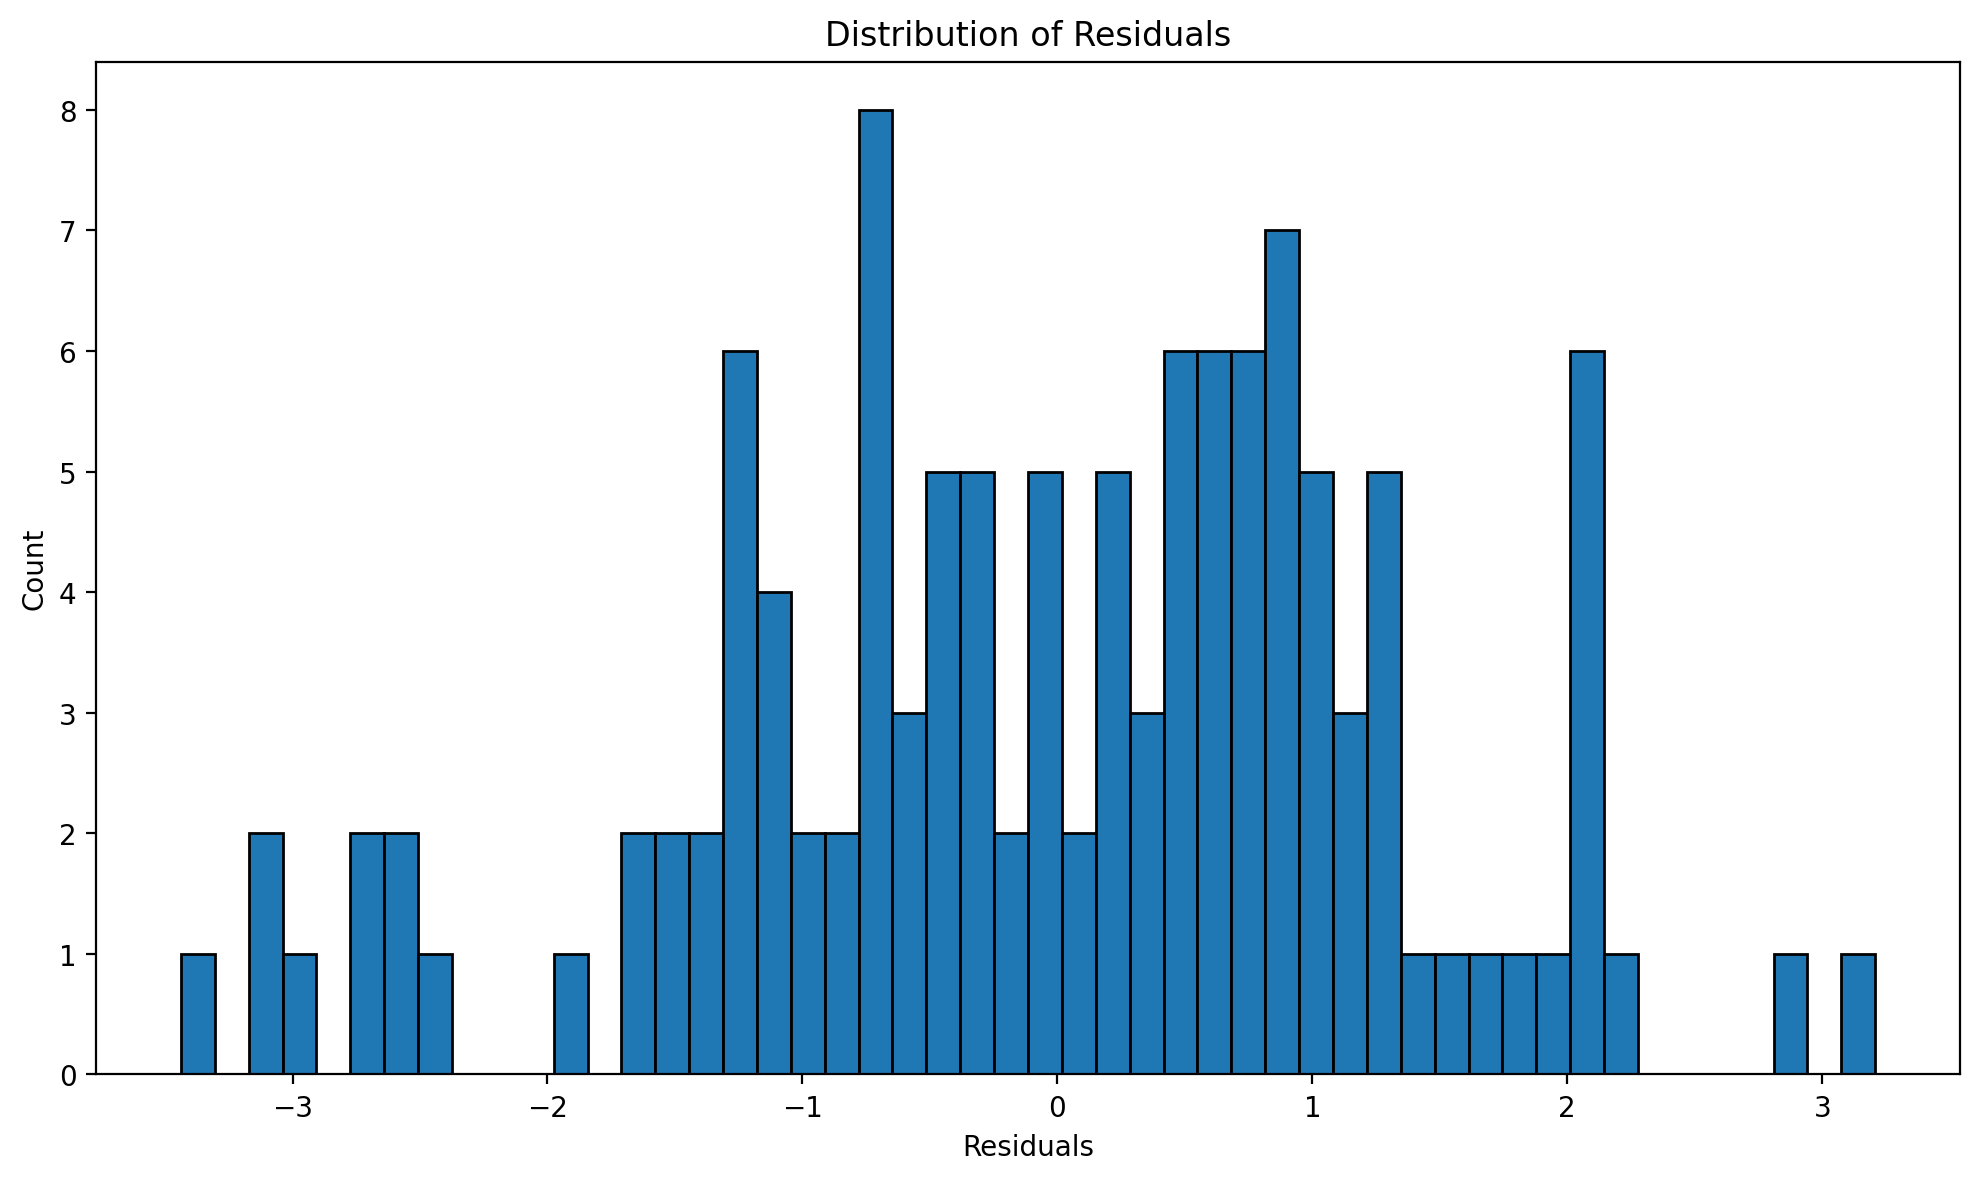

In [30]:
# Distribution of residuals
fig, ax = result_states.plot_residuals(kind="histogram")
plt.tight_layout()
plt.show()

**Figure (residual distribution).** Histogram of residuals from the state two-way FE model; used to assess normality of the error term.

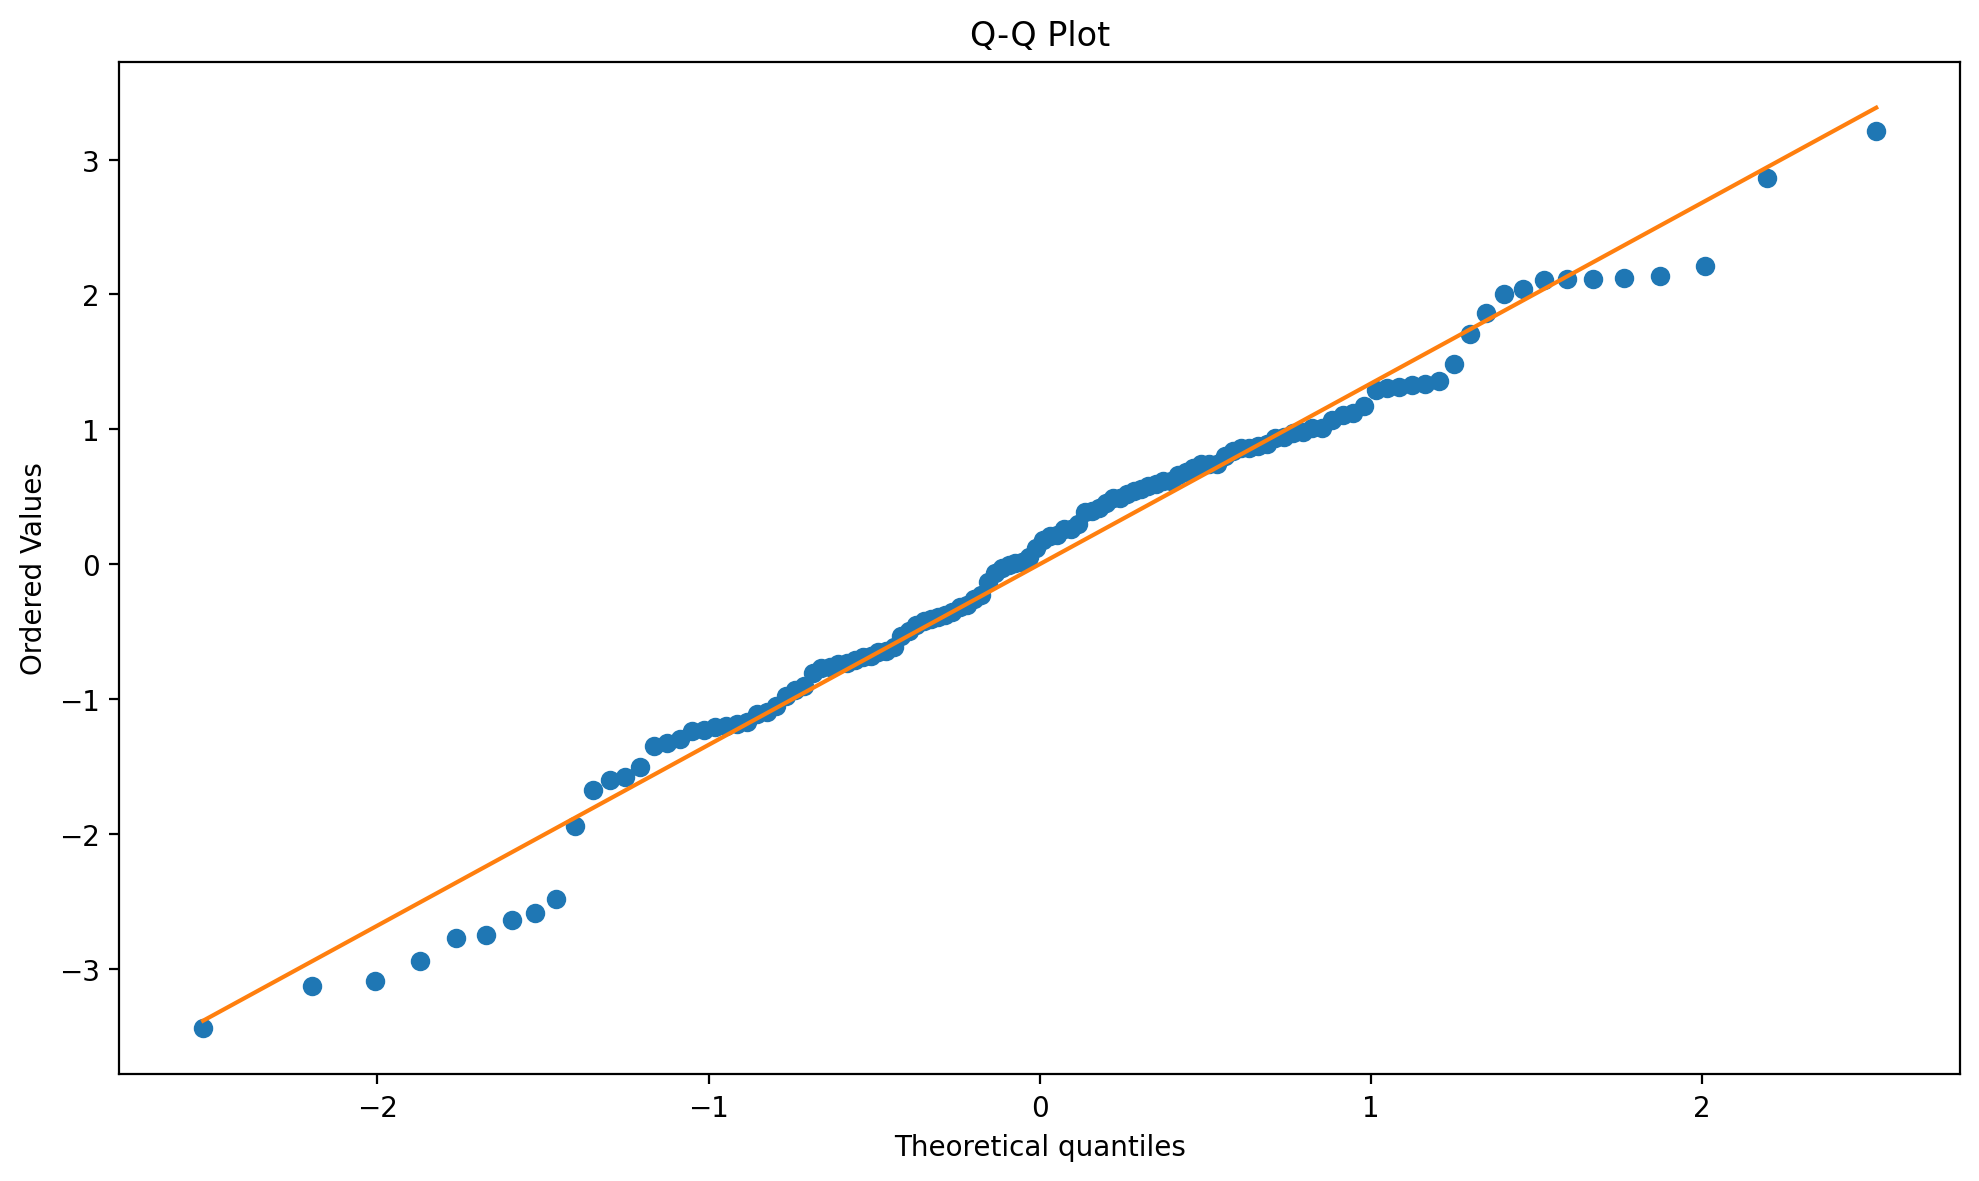

In [31]:
# Q-Q plot
fig, ax = result_states.plot_residuals(kind="qq")
plt.tight_layout()
plt.show()

**Figure (Q–Q plot).** Quantile-quantile plot of residuals vs theoretical normal; used to check normality of the error distribution.

## Summary

**Key takeaways**

- **Panel data** = same units over time; **fixed effects** use this structure to control for unobserved **unit** and/or **time** confounders.
- **Unit FE** removes time-invariant unit confounders; **time FE** removes common period shocks; **two-way FE** does both (and underlies DiD).
- FE requires **no time-varying confounders**, **strict exogeneity**, and **within-unit variation** in treatment.
- **Demeaning** and **dummy variables** give the same treatment-effect estimate; use demeaning for large N.
- FE **cannot** remove confounders that vary in both dimensions or **reverse causality**.

### When to use fixed effects

✅ **Use Panel Fixed Effects when:**
- You have repeated observations on the same units
- You suspect **time-invariant** unobserved confounders
- Your treatment varies within units over time
- You believe there are no time-varying confounders

❌ **Don't use when:**
- You only have cross-sectional data
- Your treatment is time-invariant (it gets differenced out!)
- There are likely time-varying confounders
- Outcomes feed back into future treatment

### Choosing Your Fixed Effects Specification

Use this guide to select the appropriate fixed effects for your analysis:

| Scenario | Recommended FE | Rationale |
|----------|---------------|-----------|
| Units differ in time-invariant ways only | **Unit FE only** | Controls for unit heterogeneity; preserves time variation |
| All units experience common shocks each period | **Time FE only** | Controls for period effects; preserves cross-sectional variation |
| Both unit heterogeneity AND common time trends | **Two-way FE** | Controls for both; standard for DiD-style analyses |
| Time effects already captured by covariates | **Unit FE only** | Avoid over-controlling |
| Treatment is staggered across units | **Two-way FE** | Essential for valid DiD interpretation |

Key Considerations

1. **More FE is not always better:** Adding fixed effects removes variation that could be useful for identification. Over-controlling can increase standard errors and even introduce bias.
2. **Think about your DAG:** What confounders exist? Are they time-invariant (unit FE), common across units (time FE), or both?
3. **Treatment variation matters:** 
   - If treatment only varies across units (not time), unit FE will absorb all treatment variation!
   - If treatment only varies over time (not units), time FE will absorb all treatment variation!
4. **Test sensitivity:** When in doubt, run both one-way and two-way FE. If results differ substantially, investigate why.


### Dummies vs Within

| Criterion | Dummies | Within |
|-----------|---------|--------|
| **When** | Small N (< 100) | Large N (100+) |
| **Pros** | Individual unit effects | Scales to large N |
| **Cons** | Doesn't scale | Can't estimate individual effects |
| **Formula** | `y ~ C(unit) + X` | `y ~ X` |

### Limitations and Caveats

Before concluding, let's be explicit about what fixed effects **cannot** do:

* 1. **Cannot Remove Time-Varying Confounders:** As demonstrated in our failure example, if unobserved factors change over time and affect both treatment and outcome, fixed effects will be biased. This is the most common limitation.

* 2. **Cannot Solve Reverse Causality:** If the outcome affects future treatment (feedback), fixed effects estimates are biased. Example: if poor sales cause firms to adopt new technology, we cannot estimate the effect of technology on sales using FE.

* 3. **Removes Time-Invariant Variation:** Fixed effects identifies effects from **within-unit variation only**. If your treatment barely varies within units, you have limited identifying variation and imprecise estimates.

* 4. **Assumes Common Time Effects (Two-Way FE):** With time fixed effects, you assume all units would follow parallel trends absent treatment. This may not hold if different units have different trajectories.

## References

:::{bibliography}
:filter: docname in docnames
:::
